In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve, learning_curve, cross_validate, LearningCurveDisplay
from sklearn import metrics
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# Preprocessing and EDA

In [2]:
cars = pd.read_csv('data/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'target'])

In [3]:
cars.shape

(1728, 7)

In [4]:
cars['target'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: target, dtype: int64

In [5]:
cars['target'] = cars['target'].apply(lambda x: 0 if x == 'unacc' else 1)

In [6]:
cars['target'].value_counts()

0    1210
1     518
Name: target, dtype: int64

In [7]:
cars.describe(include='all')

buying  maint doors persons lug_boot safety       target
count    1728   1728  1728    1728     1728   1728  1728.000000
unique      4      4     4       3        3      3          NaN
top     vhigh  vhigh     2       2    small    low          NaN
freq      432    432   432     576      576    576          NaN
mean      NaN    NaN   NaN     NaN      NaN    NaN     0.299769
std       NaN    NaN   NaN     NaN      NaN    NaN     0.458289
min       NaN    NaN   NaN     NaN      NaN    NaN     0.000000
25%       NaN    NaN   NaN     NaN      NaN    NaN     0.000000
50%       NaN    NaN   NaN     NaN      NaN    NaN     0.000000
75%       NaN    NaN   NaN     NaN      NaN    NaN     1.000000
max       NaN    NaN   NaN     NaN      NaN    NaN     1.000000

<AxesSubplot: xlabel='buying', ylabel='count'>

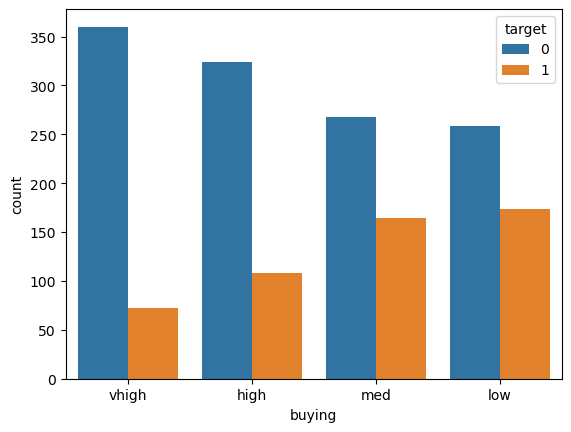

In [8]:
sns.countplot(data=cars, x='buying', hue = 'target')

<AxesSubplot: xlabel='maint', ylabel='count'>

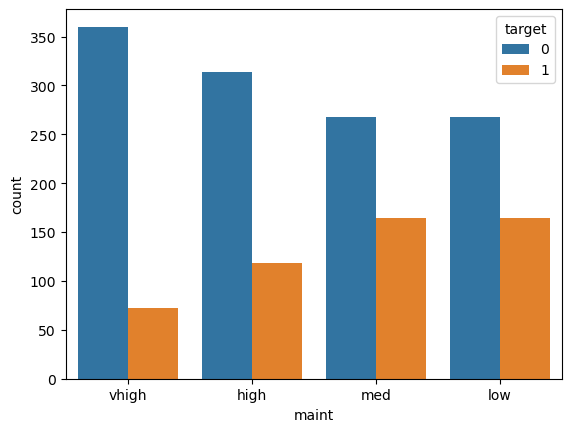

In [9]:
sns.countplot(data=cars, x='maint', hue = 'target')

<AxesSubplot: xlabel='doors', ylabel='count'>

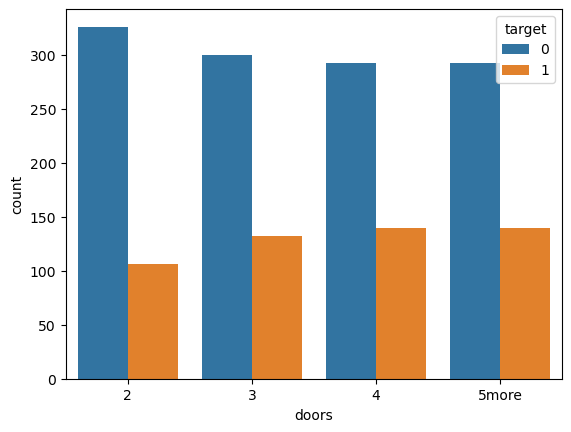

In [10]:
sns.countplot(data=cars, x='doors', hue = 'target')

<AxesSubplot: xlabel='persons', ylabel='count'>

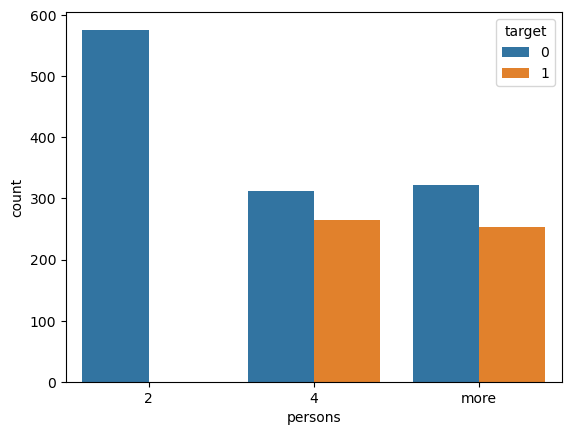

In [11]:
sns.countplot(data=cars, x='persons', hue = 'target')

<AxesSubplot: xlabel='lug_boot', ylabel='count'>

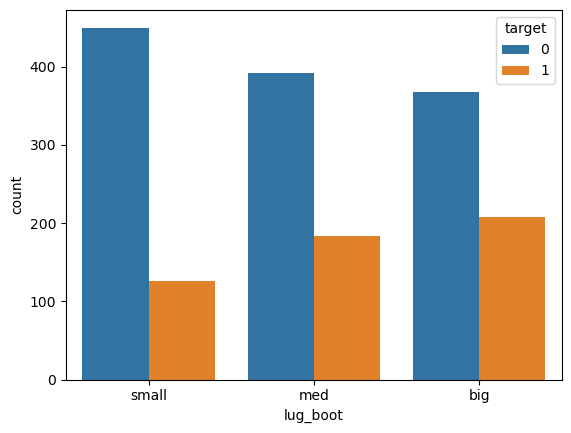

In [12]:
sns.countplot(data=cars, x='lug_boot', hue = 'target')

<AxesSubplot: xlabel='safety', ylabel='count'>

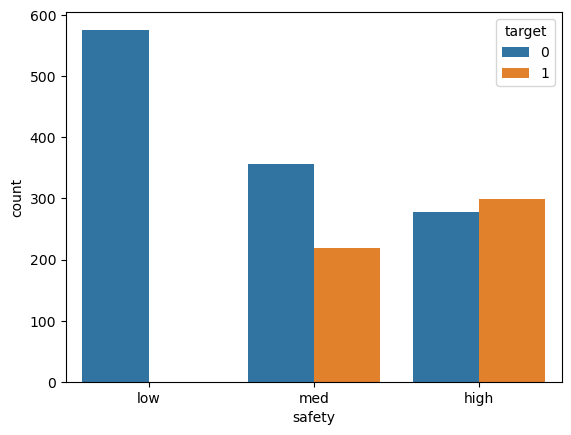

In [13]:
sns.countplot(data=cars, x='safety', hue = 'target')

In [14]:
X = cars['target']

skencoder = OneHotEncoder(drop='first',sparse_output=False)
skencoder.set_output(transform="pandas")
ohe_cars = skencoder.fit_transform(cars.loc[:,['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']])
ohe_cars['target'] = X

In [15]:
ohe_cars.head()

buying_low  buying_med  buying_vhigh  maint_low  maint_med  maint_vhigh  \
0         0.0         0.0           1.0        0.0        0.0          1.0   
1         0.0         0.0           1.0        0.0        0.0          1.0   
2         0.0         0.0           1.0        0.0        0.0          1.0   
3         0.0         0.0           1.0        0.0        0.0          1.0   
4         0.0         0.0           1.0        0.0        0.0          1.0   

   doors_3  doors_4  doors_5more  persons_4  persons_more  lug_boot_med  \
0      0.0      0.0          0.0        0.0           0.0           0.0   
1      0.0      0.0          0.0        0.0           0.0           0.0   
2      0.0      0.0          0.0        0.0           0.0           0.0   
3      0.0      0.0          0.0        0.0           0.0           1.0   
4      0.0      0.0          0.0        0.0           0.0           1.0   

   lug_boot_small  safety_low  safety_med  target  
0             1.0         1.0         0.0       0  
1             1.0         0.0         1.0       0  
2             1.0         0.0         0.0       0  
3             0.0         1.0         0.0       0  
4             0.0         0.0         1.0       0

In [16]:
ohe_cars['target'].value_counts()

0    1210
1     518
Name: target, dtype: int64

In [17]:
cars_x = ohe_cars.loc[:, ohe_cars.columns != 'target']
cars_y = ohe_cars['target']

X_train, X_test, y_train, y_test = train_test_split(cars_x, cars_y, test_size = 0.2, random_state=0)

# Model Training and Experimentation

In [70]:
_random_state = 0

def get_validation_curve(classifier, X, y, param, range_lower, range_upper, step, _scoring):
   param_range = np.arange(range_lower, range_upper, step)

   train_scores, valid_scores = validation_curve(
                                 classifier,
                                 X,
                                 y,
                                 param_name=param,
                                 param_range=param_range,
                                 cv=5,
                                 scoring=_scoring)

   # Calculating mean and standard deviation of training score
   mean_train_score = np.mean(train_scores, axis = 1)
   std_train_score = np.std(train_scores, axis = 1)

   # Calculating mean and standard deviation of testing score
   mean_valid_score = np.mean(valid_scores, axis = 1)
   std_valid_score = np.std(valid_scores, axis = 1)

   # Plot mean accuracy scores for training and testing scores
   fig = plt.figure()
   plt.plot(param_range, mean_train_score,
      label = "Training Score", color = 'b')
   plt.plot(param_range, mean_valid_score,
      label = "Cross Validation Score", color = 'g')

   # Creating the plot
   plt.title(f"Validation Curve with {classifier.__class__.__name__}")
   plt.xlabel(param)
   plt.ylabel(_scoring)
   plt.tight_layout()
   plt.legend(loc = 'best')
   return fig, mean_train_score, mean_valid_score

def cross_validation(model, _X, _y, _cv=5):
   '''Function to perform 5 Folds Cross-Validation
      Parameters
      ----------
   model: Python Class, default=None
            This is the machine learning algorithm to be used for training.
   _X: array
         This is the matrix of features.
   _y: array
         This is the target variable.
   _cv: int, default=5
         Determines the number of folds for cross-validation.
      Returns
      -------
      The function returns a dictionary containing the metrics 'accuracy', 'precision',
      'recall', 'f1' for both training set and validation set.
   '''
   _scoring = ['accuracy', 'precision', 'recall', 'f1']
   results = cross_validate(estimator=model,
                              X=_X,
                              y=_y,
                              cv=_cv,
                              scoring=_scoring,
                              return_train_score=True)
      
   return {"Training Accuracy scores": results['train_accuracy'],
            "Mean Training Accuracy": results['train_accuracy'].mean()*100,
            "Training Precision scores": results['train_precision'],
            "Mean Training Precision": results['train_precision'].mean(),
            "Training Recall scores": results['train_recall'],
            "Mean Training Recall": results['train_recall'].mean(),
            "Training F1 scores": results['train_f1'],
            "Mean Training F1 Score": results['train_f1'].mean(),
            "Validation Accuracy scores": results['test_accuracy'],
            "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
            "Validation Precision scores": results['test_precision'],
            "Mean Validation Precision": results['test_precision'].mean(),
            "Validation Recall scores": results['test_recall'],
            "Mean Validation Recall": results['test_recall'].mean(),
            "Validation F1 scores": results['test_f1'],
            "Mean Validation F1 Score": results['test_f1'].mean()
            }

def plot_cv_result_avg(x_label, y_label, plot_title, train_data, val_data):
   '''Function to plot a grouped bar chart showing the training and validation
      results of the ML model in each fold after applying K-fold cross-validation.
   Parameters
   ----------
   x_label: str, 
      Name of the algorithm used for training e.g 'Decision Tree'
      
   y_label: str, 
      Name of metric being visualized e.g 'Accuracy'
   plot_title: str, 
      This is the title of the plot e.g 'Accuracy Plot'
   
   train_result: list, array
      This is the list containing either training precision, accuracy, or f1 score.
   
   val_result: list, array
      This is the list containing either validation precision, accuracy, or f1 score.
   Returns
   -------
   The function returns a Grouped Barchart showing the training and validation result
   in each fold.
   '''
   
   # Set size of plot
   plt.figure(figsize=(12,6))
   # labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
   labels = ['avg']
   X_axis = np.arange(len(labels))
   ax = plt.gca()
   plt.ylim(0.40000, 1)
   plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
   plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
   plt.title(plot_title, fontsize=30)
   plt.xticks(X_axis, labels)
   plt.xlabel(x_label, fontsize=14)
   plt.ylabel(y_label, fontsize=14)
   plt.legend()
   plt.grid(True)
   plt.show()

def plot_cv_result(x_label, y_label, plot_title, train_data, val_data):
   '''Function to plot a grouped bar chart showing the training and validation
      results of the ML model in each fold after applying K-fold cross-validation.
   Parameters
   ----------
   x_label: str, 
      Name of the algorithm used for training e.g 'Decision Tree'
      
   y_label: str, 
      Name of metric being visualized e.g 'Accuracy'
   plot_title: str, 
      This is the title of the plot e.g 'Accuracy Plot'
   
   train_result: list, array
      This is the list containing either training precision, accuracy, or f1 score.
   
   val_result: list, array
      This is the list containing either validation precision, accuracy, or f1 score.
   Returns
   -------
   The function returns a Grouped Barchart showing the training and validation result
   in each fold.
   '''
   
   # Set size of plot
   plt.figure(figsize=(12,6))
   labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
   X_axis = np.arange(len(labels))
   ax = plt.gca()
   plt.ylim(0.40000, 1)
   plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
   plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
   plt.title(plot_title, fontsize=30)
   plt.xticks(X_axis, labels)
   plt.xlabel(x_label, fontsize=14)
   plt.ylabel(y_label, fontsize=14)
   plt.legend()
   plt.grid(True)
   plt.show()

def model_evaluation(y_test, y_pred):
   accuracy = metrics.accuracy_score(y_test, y_pred)
   f1 = metrics.f1_score(y_test, y_pred)
   return accuracy, f1

def get_training_time(model, X, y):
   training_sizes = np.arange(100, 1100, 25)
   training_times = []
   for train_size in training_sizes:
      i = np.random.randint(X.shape[0], size=train_size)
      X_subset = X.iloc[i,:]
      y_subset = y.iloc[i]
      scores = cross_validate(model, X_subset, y_subset, cv=5, scoring='f1', return_train_score=True)
      avg_time = np.mean(scores['fit_time'])
      training_times.append(avg_time)
   
   plt.plot(training_sizes, training_times,
      label = "Training Time", color = 'b')
   # Creating the plot
   plt.title(f"Training Times with {model.__class__.__name__}")
   plt.xlabel("Num. Samples")
   plt.ylabel("Training Time")
   plt.tight_layout()
   plt.legend(loc = 'best')
   plt.show()

## Decision Tree

### Information Gain

#### Entropy

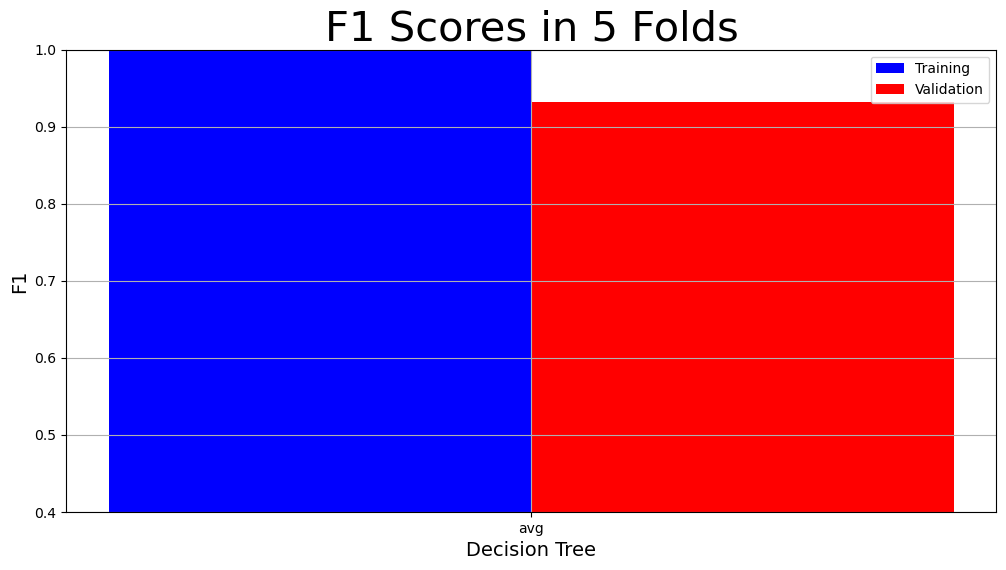

Train F1 mean:  1.0
Validation F1 mean:  0.9320742943994986


In [24]:
decision_tree_model = DecisionTreeClassifier(criterion="entropy",
                                     random_state=_random_state)
decision_tree_result = cross_validation(decision_tree_model, X_train, y_train, 5)

# Plot F1 Result
model_name = "Decision Tree"
plot_cv_result_avg(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            decision_tree_result["Training F1 scores"].mean(),
            decision_tree_result["Validation F1 scores"].mean())

print("Train F1 mean: ", decision_tree_result["Training F1 scores"].mean())
print("Validation F1 mean: ", decision_tree_result["Validation F1 scores"].mean())

#### Gini

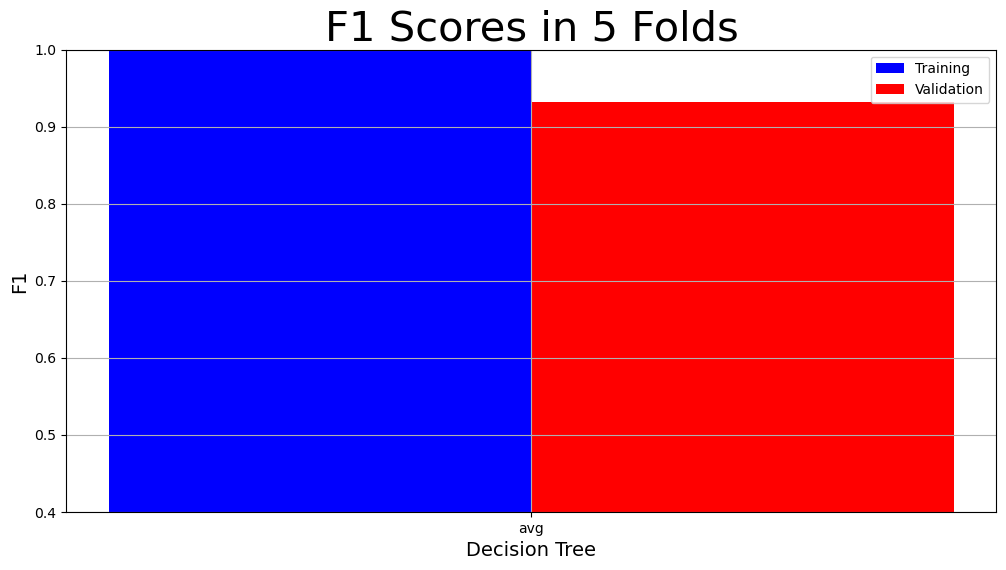

Train F1 mean:  1.0
Validation F1 mean:  0.9324879379467793


In [25]:
decision_tree_model = DecisionTreeClassifier(criterion="gini",
                                     random_state=_random_state)
decision_tree_result = cross_validation(decision_tree_model, X_train, y_train, 5)

# Plot F1 Result
model_name = "Decision Tree"
plot_cv_result_avg(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            decision_tree_result["Training F1 scores"].mean(),
            decision_tree_result["Validation F1 scores"].mean())

print("Train F1 mean: ", decision_tree_result["Training F1 scores"].mean())
print("Validation F1 mean: ", decision_tree_result["Validation F1 scores"].mean())

#### Log Loss

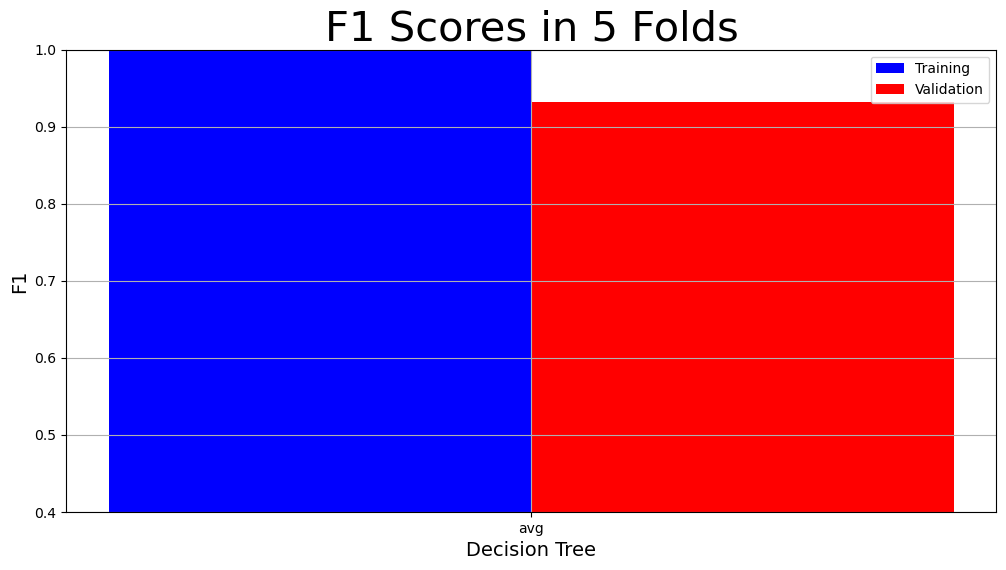

Train F1 mean:  1.0
Validation F1 mean:  0.9320742943994986


In [26]:
decision_tree_model = DecisionTreeClassifier(criterion="log_loss",
                                     random_state=_random_state)
decision_tree_result = cross_validation(decision_tree_model, X_train, y_train, 5)

# Plot F1 Result
model_name = "Decision Tree"
plot_cv_result_avg(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            decision_tree_result["Training F1 scores"].mean(),
            decision_tree_result["Validation F1 scores"].mean())

print("Train F1 mean: ", decision_tree_result["Training F1 scores"].mean())
print("Validation F1 mean: ", decision_tree_result["Validation F1 scores"].mean())

### Validation & Learning Curves

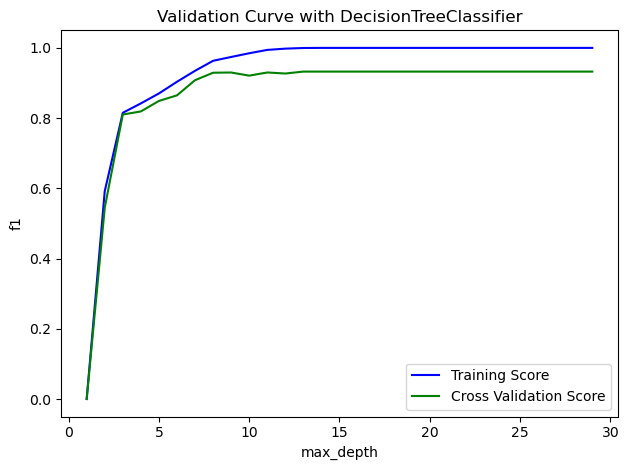

Indices: [28 19 12]
Values: [0.93248794 0.93248794 0.93248794]


In [92]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "max_depth", 1, 30, 1, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

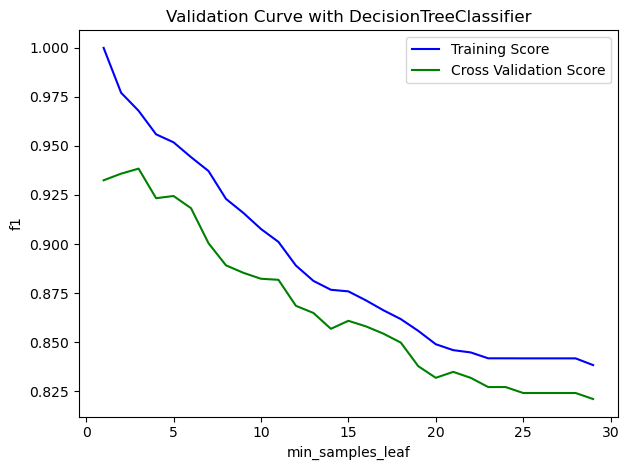

Indices: [2 1 0]
Values: [0.93843266 0.93586802 0.93248794]


In [93]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "min_samples_leaf", 1, 30, 1, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

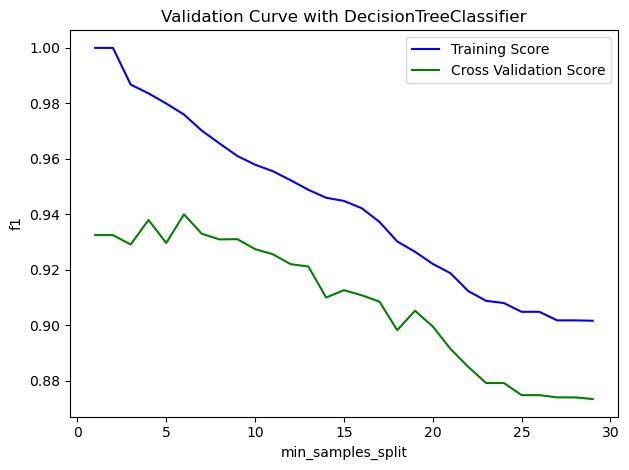

Indices: [5 3 6]
Values: [0.93997271 0.93793731 0.93295095]


In [94]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "min_samples_split", 1, 30, 1, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

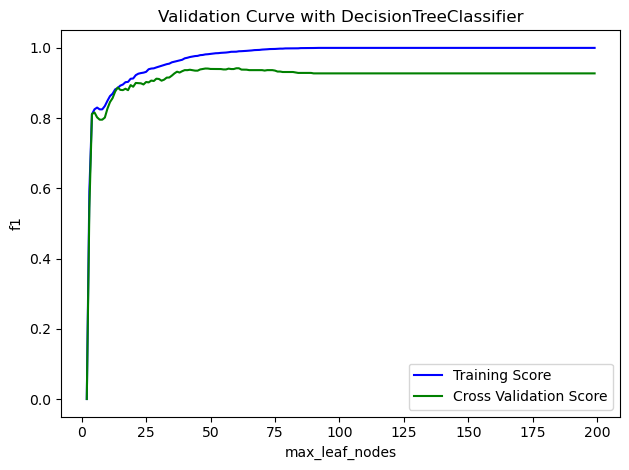

Indices: [ 0 60 59]
Values: [      nan 0.9419794 0.9419794]


In [95]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "max_leaf_nodes", 1, 200, 1, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

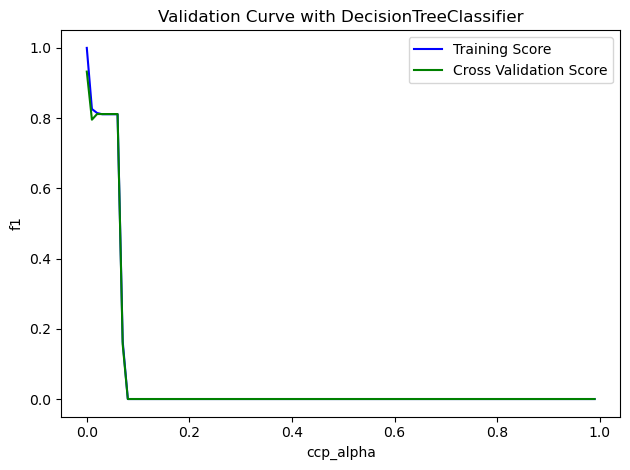

Indices: [0 6 3]
Values: [0.93248794 0.81158133 0.81158133]


In [96]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "ccp_alpha", 0, 1, 0.01, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

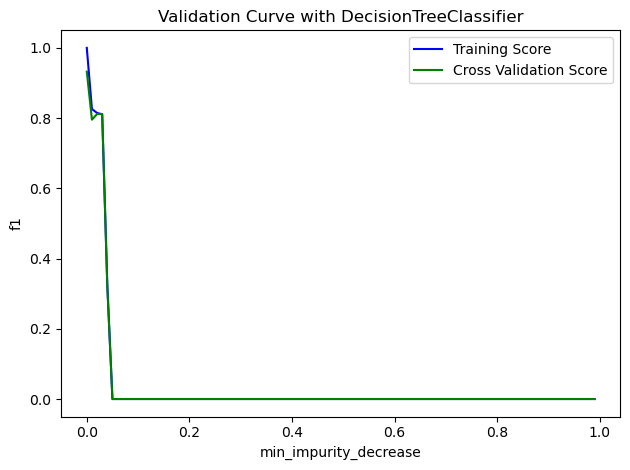

Indices: [0 3 2]
Values: [0.93248794 0.81158133 0.81157036]


In [97]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "min_impurity_decrease", 0, 1, 0.01, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

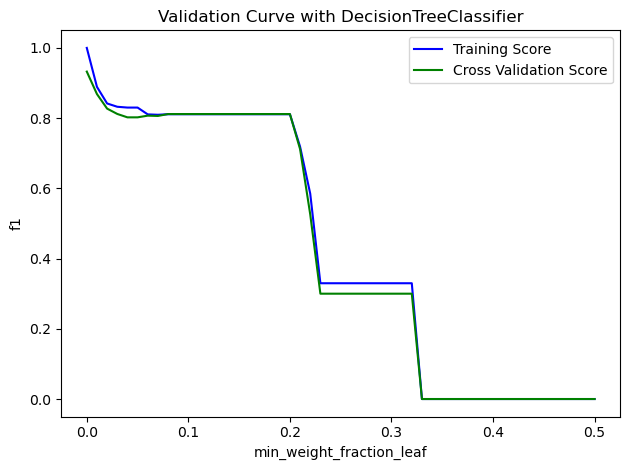

Indices: [99 74 72]
Values: [nan nan nan]


In [98]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "min_weight_fraction_leaf", 0, 1, 0.01, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

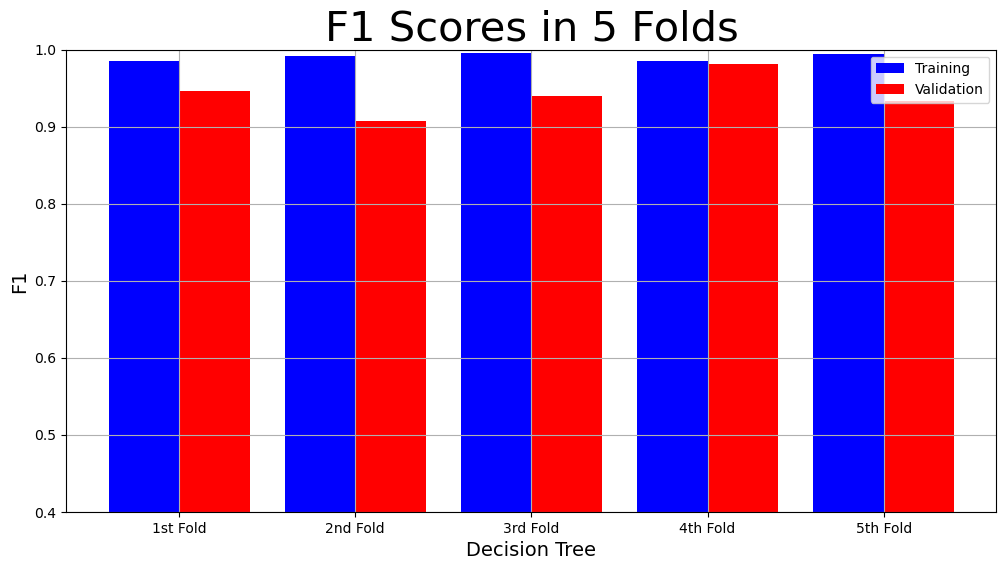

Train F1:  [0.98502994 0.99245852 0.99547511 0.98489426 0.9939577 ]
Validation F1:  [0.94674556 0.90797546 0.94047619 0.98136646 0.93333333]
Average Validation F1:  0.9419794011379459


In [101]:
# # cross validation on all hyperparameters
# decision_tree_model = DecisionTreeClassifier(criterion="gini",
#                                      max_leaf_nodes=48,
#                                      min_samples_split=4,
#                                      max_depth=9,
#                                      min_samples_leaf=3,
#                                      random_state=_random_state)
# decision_tree_result = cross_validation(decision_tree_model, X_train, y_train, 5)

# # Plot F1 Result
# model_name = "Decision Tree"
# plot_cv_result(model_name,
#             "F1",
#             "F1 Scores in 5 Folds",
#             decision_tree_result["Training F1 scores"],
#             decision_tree_result["Validation F1 scores"])

# print("Train F1: ", decision_tree_result["Training F1 scores"])
# print("Validation F1: ", decision_tree_result["Validation F1 scores"])
# print("Average Validation F1: ", np.mean(decision_tree_result["Validation F1 scores"]))

# cross validation on all hyperparameters
decision_tree_model = DecisionTreeClassifier(criterion="gini",
                                     max_leaf_nodes=61,
                                    #  min_samples_split=6,
                                     max_depth=13,
                                    #  min_samples_leaf=3,
                                     random_state=_random_state)
decision_tree_result = cross_validation(decision_tree_model, X_train, y_train, 5)

# Plot F1 Result
model_name = "Decision Tree"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            decision_tree_result["Training F1 scores"],
            decision_tree_result["Validation F1 scores"])

print("Train F1: ", decision_tree_result["Training F1 scores"])
print("Validation F1: ", decision_tree_result["Validation F1 scores"])
print("Average Validation F1: ", np.mean(decision_tree_result["Validation F1 scores"]))

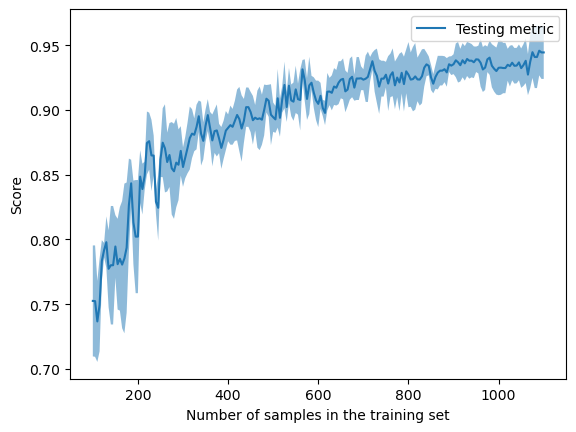

In [127]:
LearningCurveDisplay.from_estimator(
   DecisionTreeClassifier(criterion="gini",
                                     max_leaf_nodes=61,
                                     max_depth=13,
                                     random_state=_random_state), X_train, y_train, train_sizes=np.arange(100, 1105, 5), cv=5, scoring='f1')

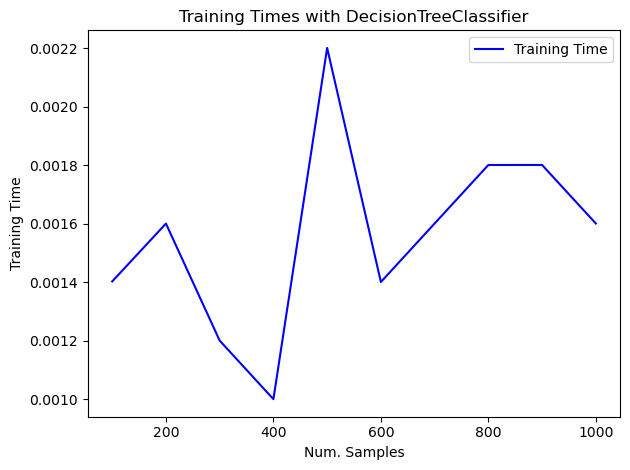

In [103]:
get_training_time(DecisionTreeClassifier(criterion="gini",
                                     max_leaf_nodes=61,
                                     max_depth=13,
                                     random_state=_random_state), X_train, y_train)

In [104]:
tree = DecisionTreeClassifier(criterion="gini",
                              max_leaf_nodes=61,
                              max_depth=13,
                              random_state=_random_state)

tree = tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

accuracy, f1 = model_evaluation(y_test, y_pred)
print('Accuracy: ', accuracy)
print('F1: ', f1)

Accuracy:  0.9450867052023122
F1:  0.91324200913242


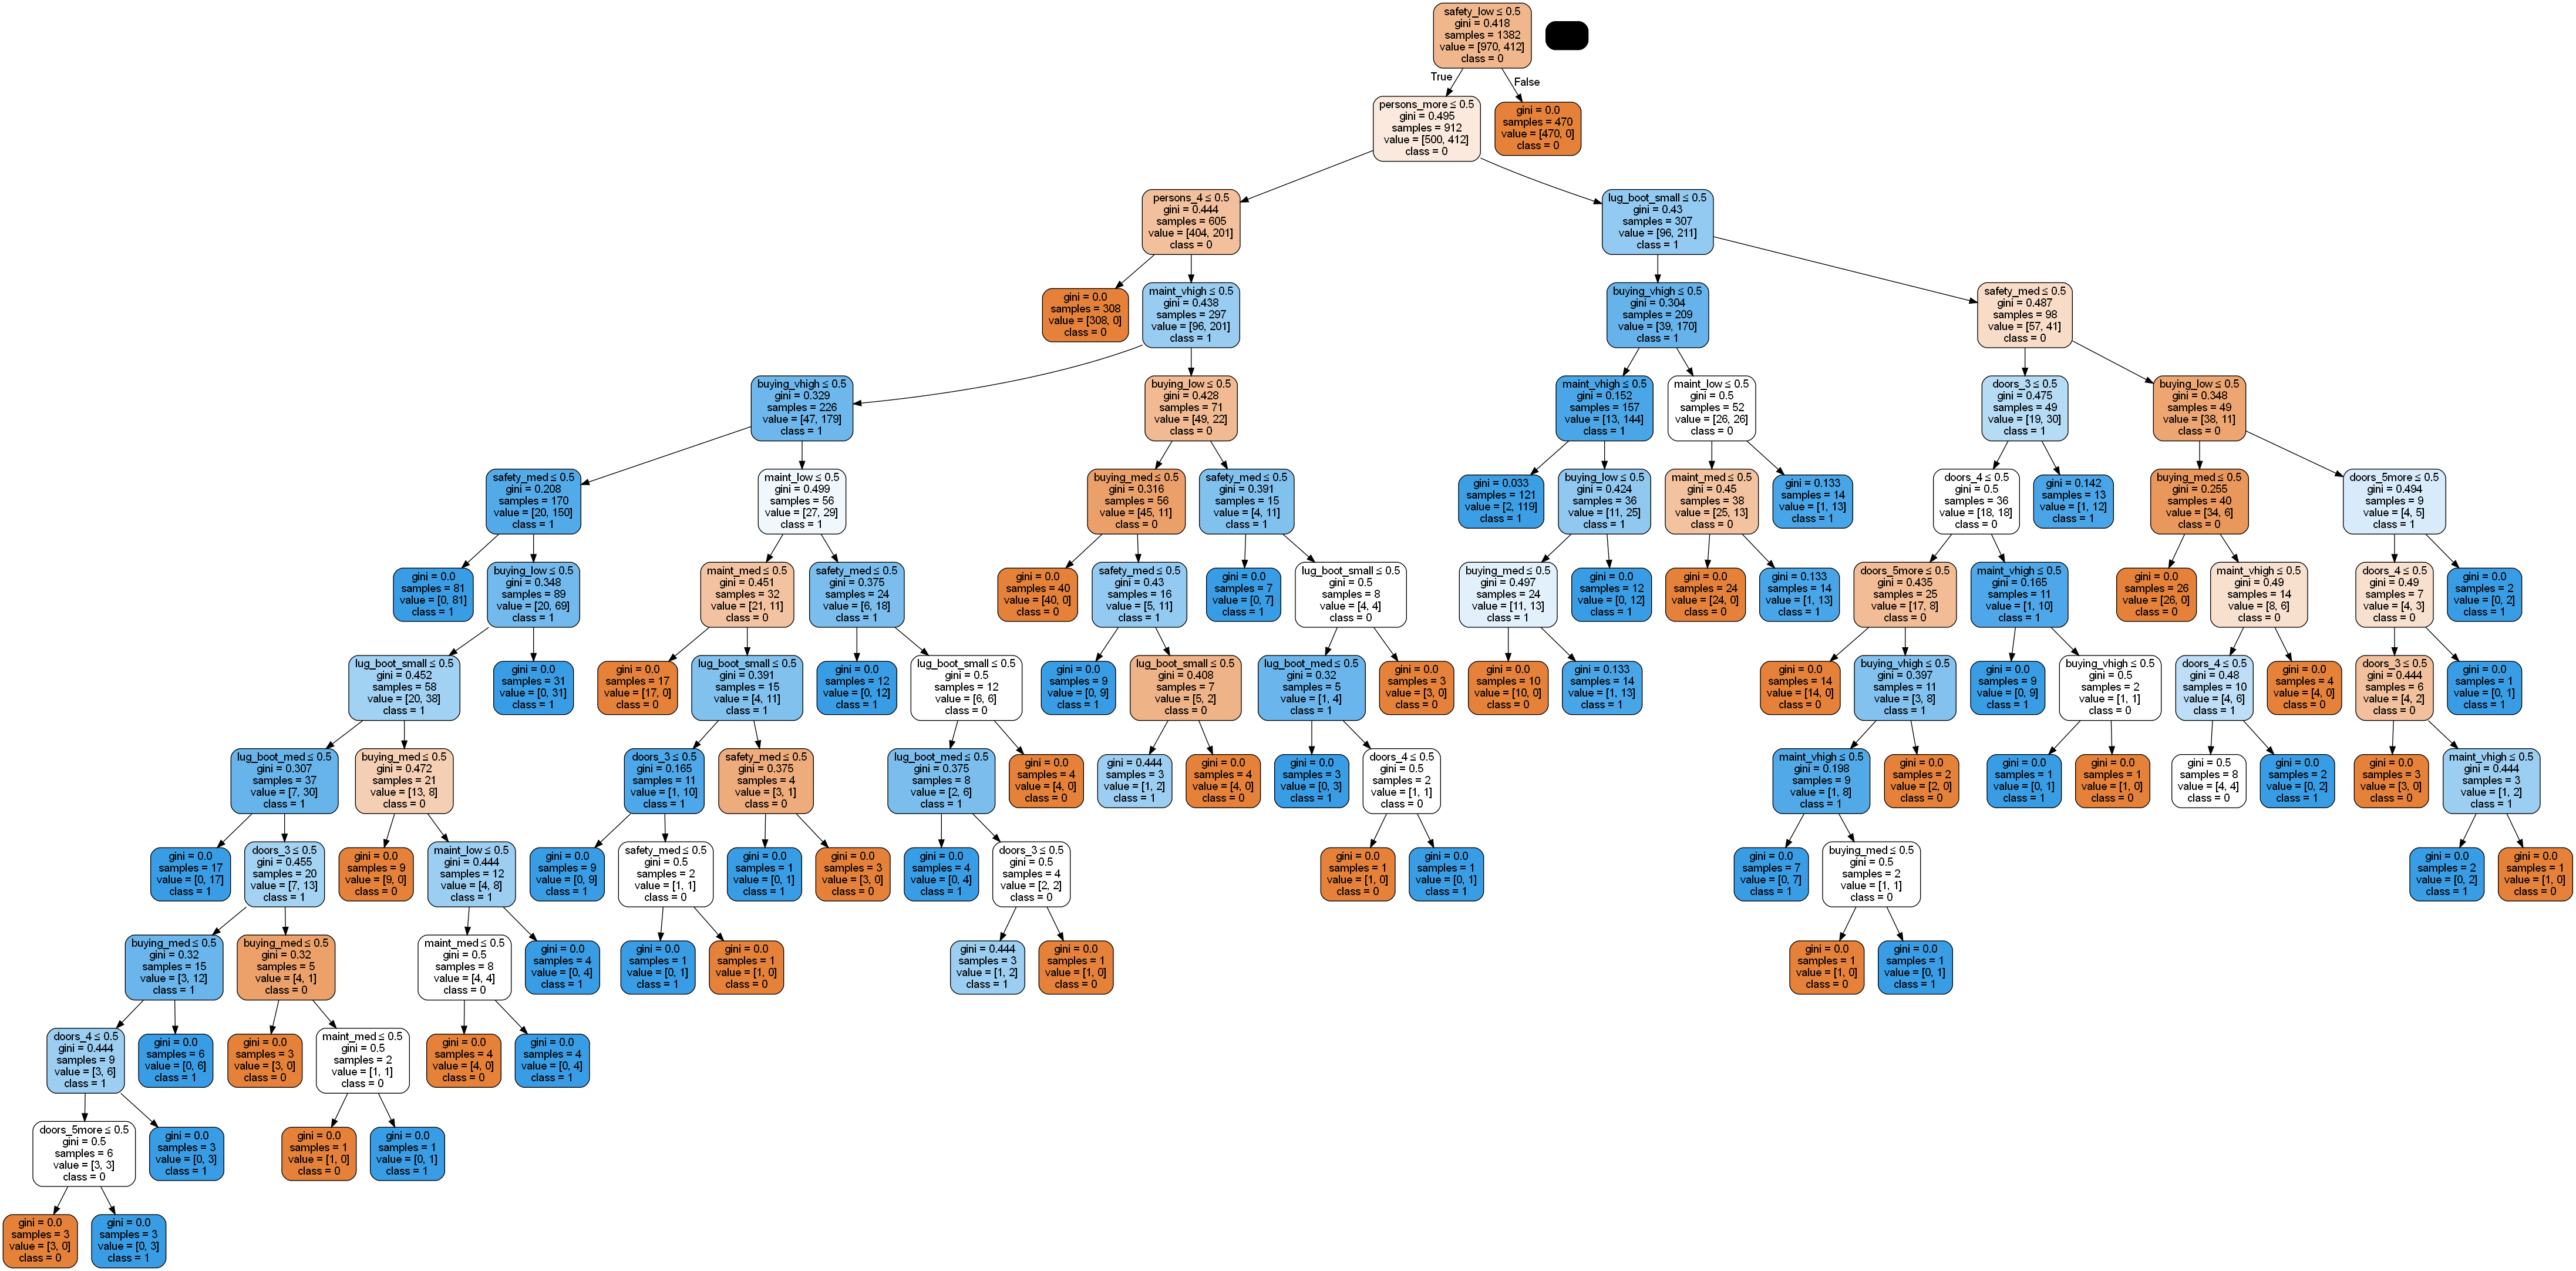

In [105]:
feature_cols = list(X_train.columns)

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

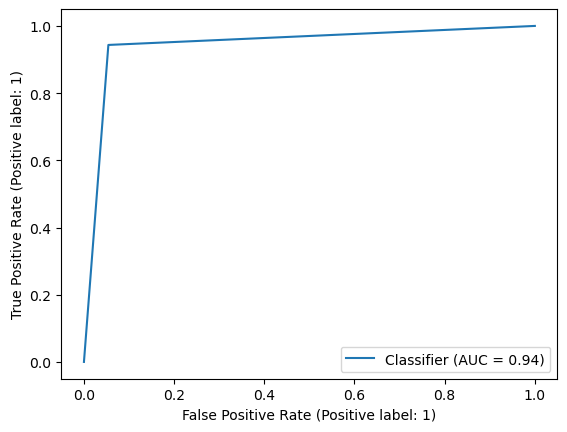

In [106]:
metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

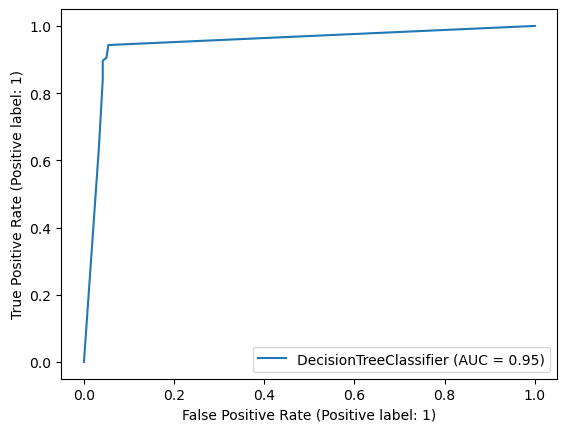

In [107]:
metrics.RocCurveDisplay.from_estimator(tree, X_test, y_test)
plt.show()

## KNN

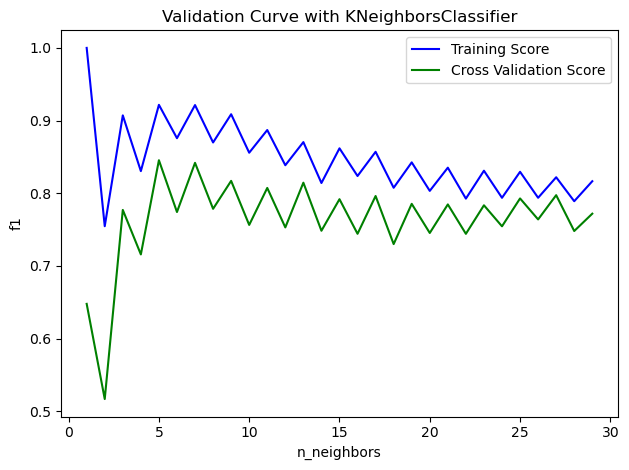

Indices: [4 6 8]
Values: [0.84544494 0.84184651 0.81704045]


In [108]:
f, train_scores, valid_scores = get_validation_curve(KNeighborsClassifier(), X_train, y_train, "n_neighbors", 1, 30, 1, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

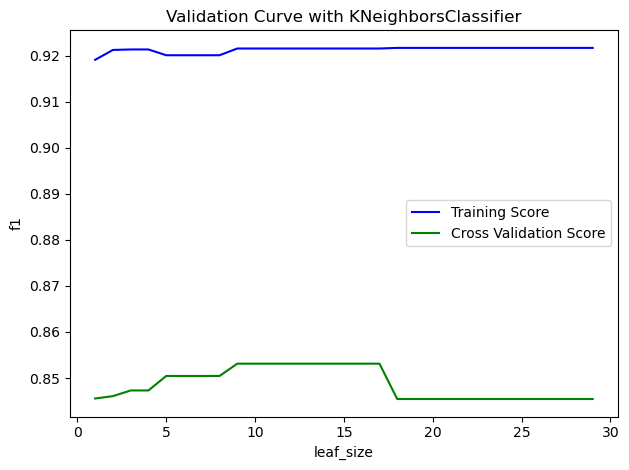

Indices: [14 12  8]
Values: [0.85312356 0.85312356 0.85312356]


In [109]:
f, train_scores, valid_scores = get_validation_curve(KNeighborsClassifier(), X_train, y_train, "leaf_size", 1, 30, 1, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

### Algorithm

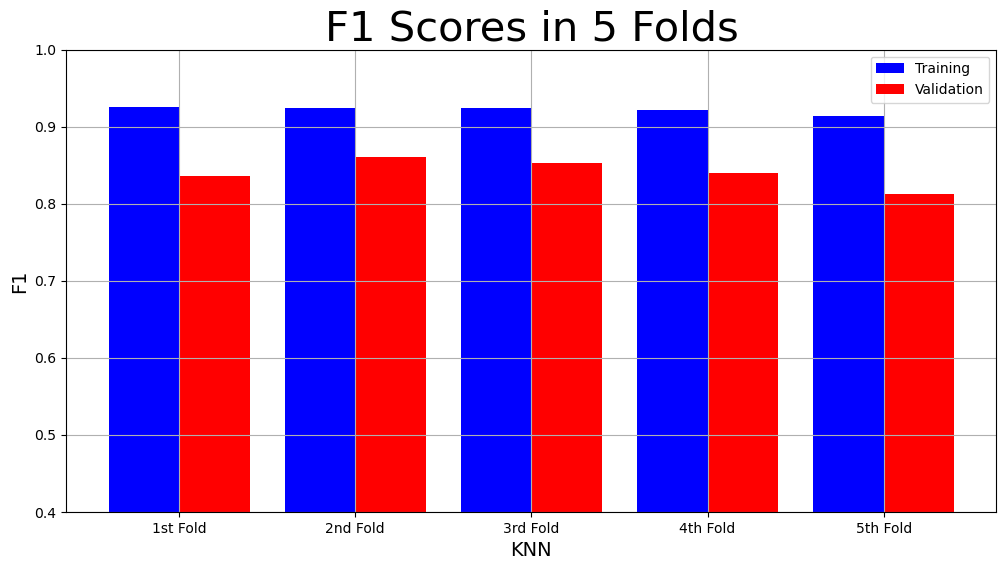

Train F1:  [0.92503987 0.92405063 0.92379471 0.92211838 0.91401274]
Validation F1:  [0.83544304 0.86075949 0.85333333 0.84       0.81290323]
Average Validation F1:  0.8404878181570709


In [44]:
# BALL TREE
knn_model = KNeighborsClassifier(algorithm="ball_tree")
knn_result = cross_validation(knn_model, X_train, y_train, 5)

# Plot F1 Result
model_name = "KNN"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            knn_result["Training F1 scores"],
            knn_result["Validation F1 scores"])

print("Train F1: ", knn_result["Training F1 scores"])
print("Validation F1: ", knn_result["Validation F1 scores"])
print("Average Validation F1: ", knn_result["Validation F1 scores"].mean())

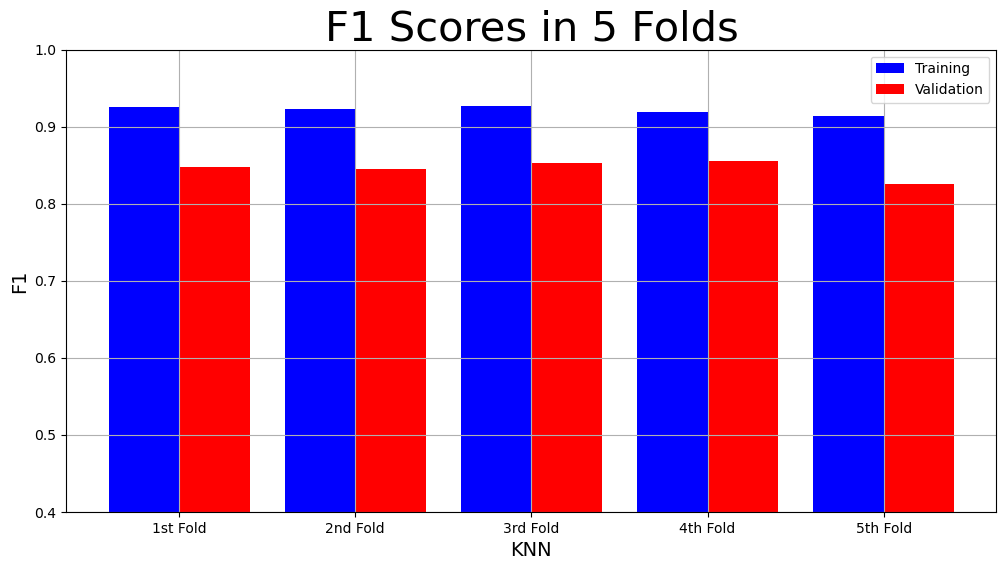

Train F1:  [0.92527822 0.92259084 0.92690513 0.91925466 0.91428571]
Validation F1:  [0.84810127 0.8447205  0.85333333 0.85526316 0.82580645]
Average Validation F1:  0.8454449411116338


In [45]:
# KD TREE
knn_model = KNeighborsClassifier(algorithm="kd_tree")
knn_result = cross_validation(knn_model, X_train, y_train, 5)

# Plot F1 Result
model_name = "KNN"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            knn_result["Training F1 scores"],
            knn_result["Validation F1 scores"])

print("Train F1: ", knn_result["Training F1 scores"])
print("Validation F1: ", knn_result["Validation F1 scores"])
print("Average Validation F1: ", knn_result["Validation F1 scores"].mean())

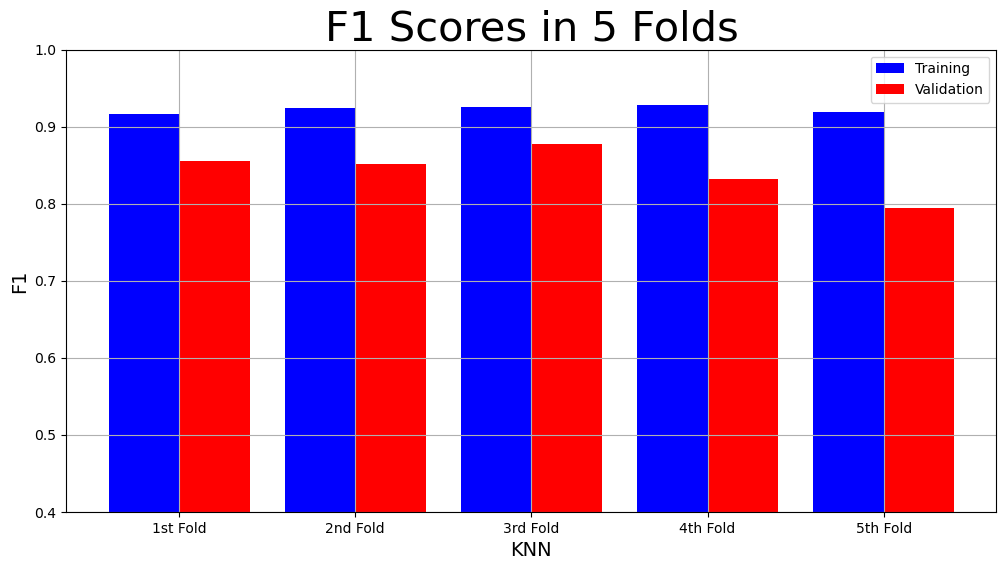

Train F1:  [0.91627172 0.92429022 0.92569659 0.928125   0.91917591]
Validation F1:  [0.85534591 0.85185185 0.87741935 0.83221477 0.79470199]
Average Validation F1:  0.8423067740991771


In [46]:
# BRUTE
knn_model = KNeighborsClassifier(algorithm="brute")
knn_result = cross_validation(knn_model, X_train, y_train, 5)

# Plot F1 Result
model_name = "KNN"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            knn_result["Training F1 scores"],
            knn_result["Validation F1 scores"])

print("Train F1: ", knn_result["Training F1 scores"])
print("Validation F1: ", knn_result["Validation F1 scores"])
print("Average Validation F1: ", knn_result["Validation F1 scores"].mean())

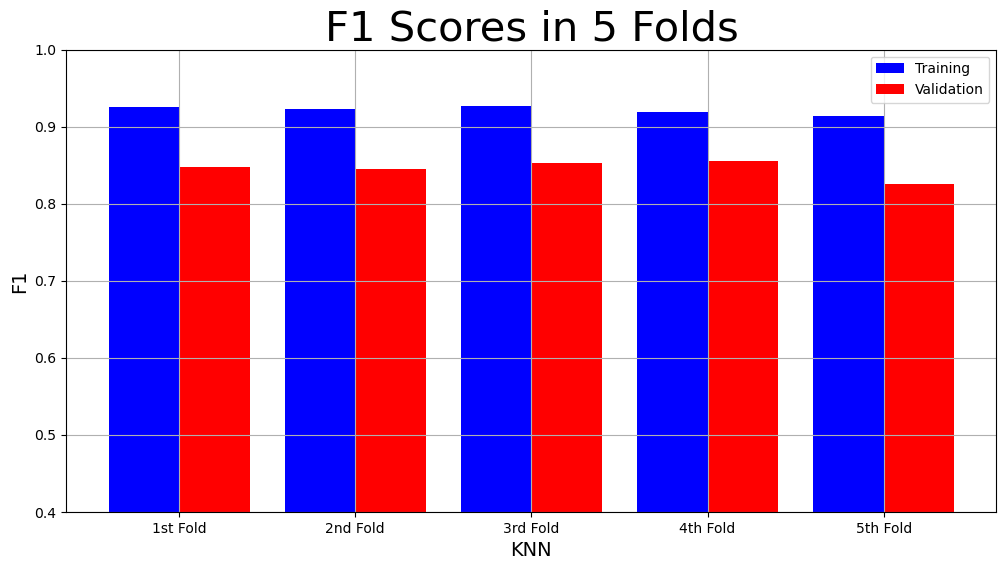

Train F1:  [0.92527822 0.92259084 0.92690513 0.91925466 0.91428571]
Validation F1:  [0.84810127 0.8447205  0.85333333 0.85526316 0.82580645]
Average Validation F1:  0.8454449411116338


In [47]:
# AUTO
knn_model = KNeighborsClassifier()
knn_result = cross_validation(knn_model, X_train, y_train, 5)

# Plot F1 Result
model_name = "KNN"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            knn_result["Training F1 scores"],
            knn_result["Validation F1 scores"])

print("Train F1: ", knn_result["Training F1 scores"])
print("Validation F1: ", knn_result["Validation F1 scores"])
print("Average Validation F1: ", knn_result["Validation F1 scores"].mean())

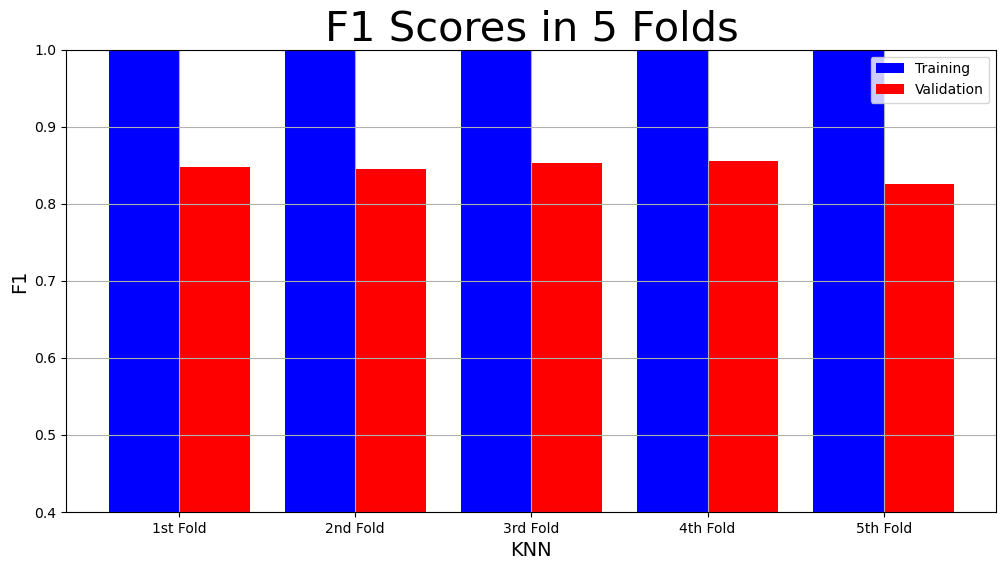

Train F1:  [1. 1. 1. 1. 1.]
Validation F1:  [0.84810127 0.8447205  0.85333333 0.85526316 0.82580645]
Average Validation F1:  0.8454449411116338


In [51]:
# WEIGHTS
knn_model = KNeighborsClassifier(weights='distance')
knn_result = cross_validation(knn_model, X_train, y_train, 5)

# Plot F1 Result
model_name = "KNN"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            knn_result["Training F1 scores"],
            knn_result["Validation F1 scores"])

print("Train F1: ", knn_result["Training F1 scores"])
print("Validation F1: ", knn_result["Validation F1 scores"])
print("Average Validation F1: ", knn_result["Validation F1 scores"].mean())

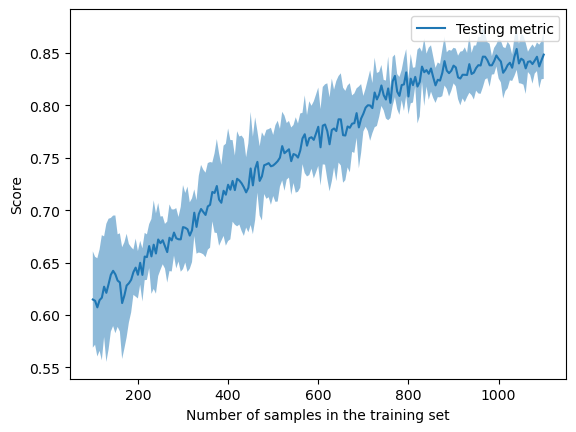

In [128]:
LearningCurveDisplay.from_estimator(
   KNeighborsClassifier(leaf_size=15), X_train, y_train, train_sizes=np.arange(100, 1105, 5), cv=5, scoring='f1')

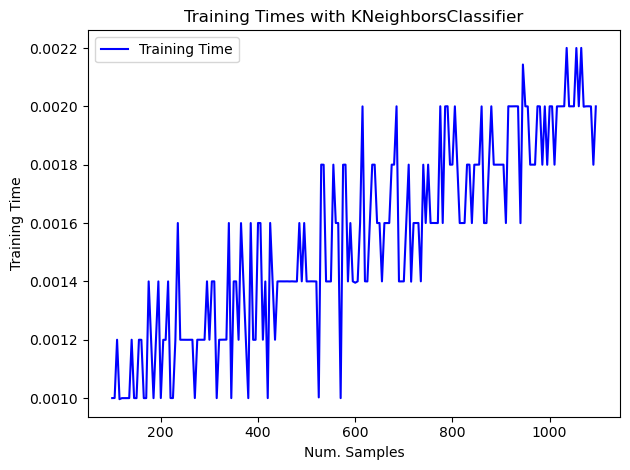

In [130]:
get_training_time(KNeighborsClassifier(leaf_size=15), X_train, y_train)

In [137]:
knn = KNeighborsClassifier(leaf_size=15)

knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy, f1 = model_evaluation(y_test, y_pred)
print('Accuracy: ', accuracy)
print('F1: ', f1)

Accuracy:  0.8872832369942196
F1:  0.7979274611398964


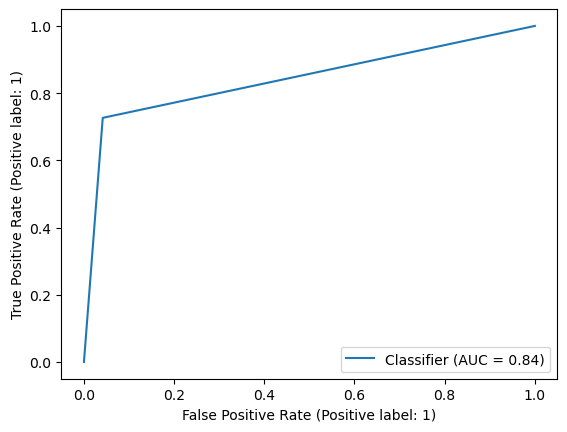

In [132]:
metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

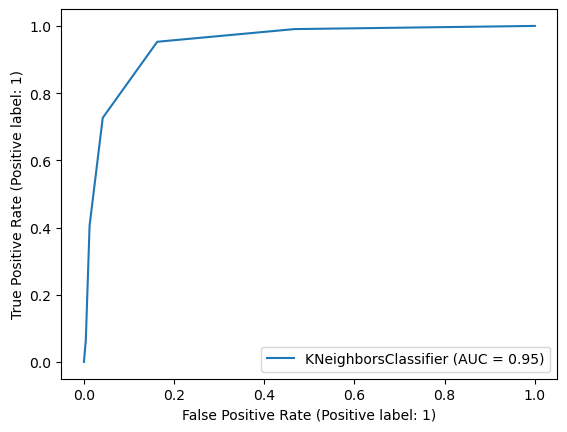

In [136]:
metrics.RocCurveDisplay.from_estimator(knn, X_test, y_test)
plt.show()

## Boosting

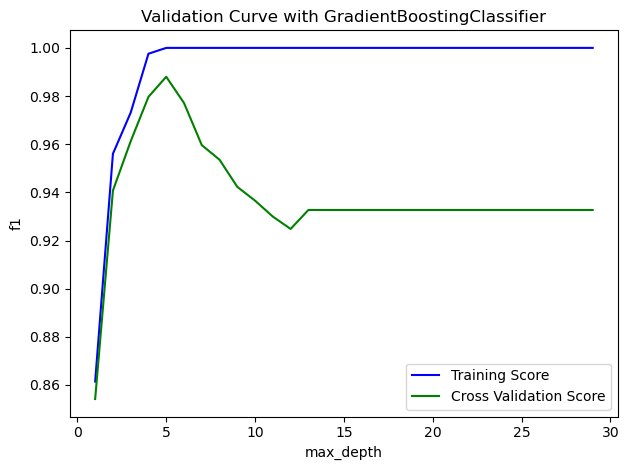

Indices: [4 3 5]
Values: [0.98800944 0.97966801 0.97711372]


In [112]:
f, train_scores, valid_scores = get_validation_curve(GradientBoostingClassifier(random_state=_random_state), X_train, y_train, "max_depth", 1, 30, 1, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

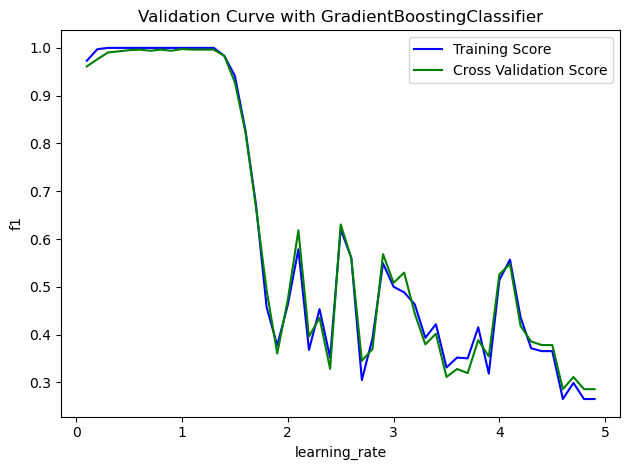

Indices: [9 7 5]
Values: [0.99757576 0.99639267 0.99639267]


In [113]:
f, train_scores, valid_scores = get_validation_curve(GradientBoostingClassifier(random_state=_random_state), X_train, y_train, "learning_rate", 0.1, 5, 0.1, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

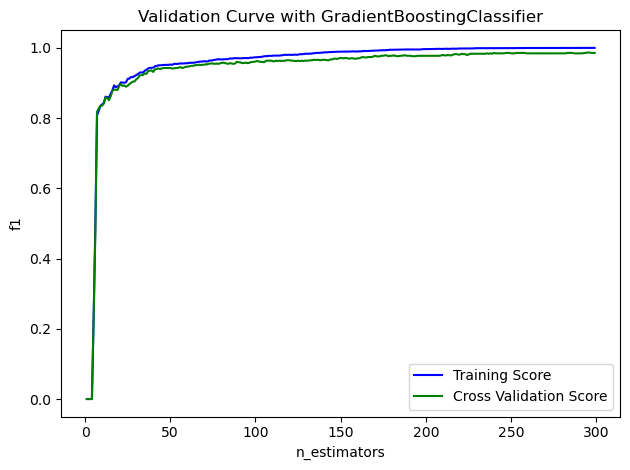

Indices: [295 294 248]
Values: [0.98683905 0.98683905 0.98565587]


In [115]:
f, train_scores, valid_scores = get_validation_curve(GradientBoostingClassifier(random_state=_random_state), X_train, y_train, "n_estimators", 1, 300, 1, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

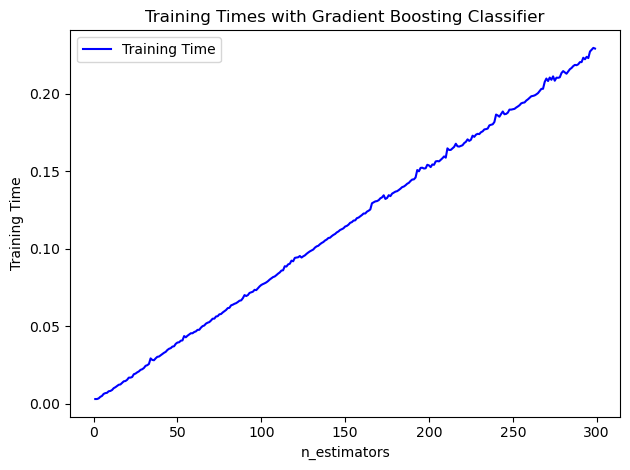

In [116]:
_n_estimators = np.arange(1, 300, 1)
training_times = []
for n in _n_estimators:
    scores = cross_validate(GradientBoostingClassifier(random_state=_random_state, n_estimators=n), X_train, y_train, cv=5, scoring='f1', return_train_score=True)
    avg_time = np.mean(scores['fit_time'])
    training_times.append(avg_time)

plt.plot(_n_estimators, training_times,
    label = "Training Time", color = 'b')
# Creating the plot
plt.title("Training Times with Gradient Boosting Classifier")
plt.xlabel("n_estimators")
plt.ylabel("Training Time")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

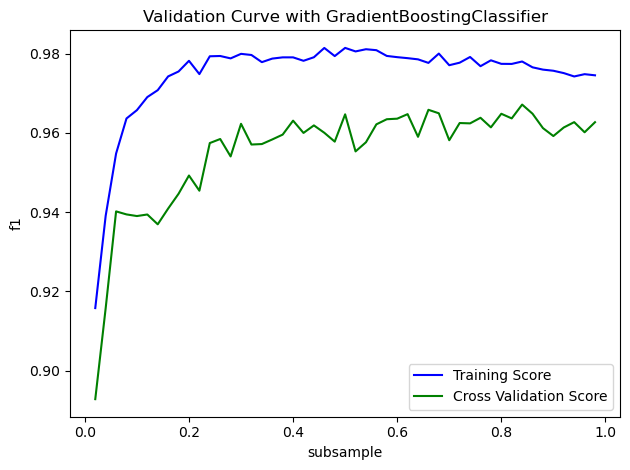

Indices: [ 0 42 33]
Values: [       nan 0.96717503 0.96585504]


In [118]:
f, train_scores, valid_scores = get_validation_curve(GradientBoostingClassifier(random_state=_random_state), X_train, y_train, "subsample", 0.0, 1, 0.02, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

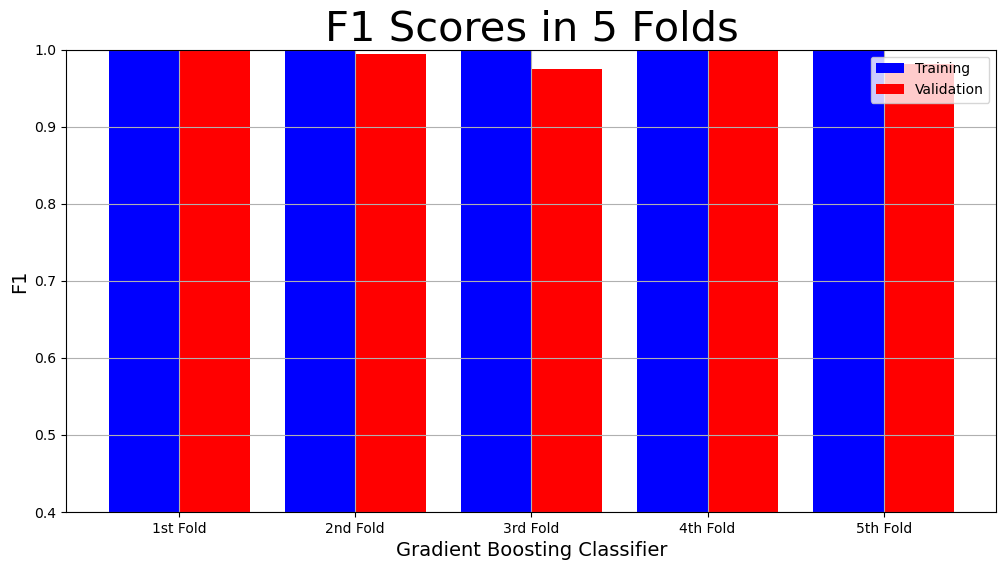

Train F1:  [1. 1. 1. 1. 1.]
Validation F1:  [1.         0.99401198 0.97560976 1.         0.98181818]
Average Validation F1:  0.9902879827927293


In [122]:
gb = GradientBoostingClassifier(max_depth=5,
                                     learning_rate=1.0,
                                     n_estimators=300,
                                     subsample=0.86,
                                     random_state=_random_state)
gb_result = cross_validation(gb, X_train, y_train, 5)

# Plot F1 Result
model_name = "Gradient Boosting Classifier"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            gb_result["Training F1 scores"],
            gb_result["Validation F1 scores"])

print("Train F1: ", gb_result["Training F1 scores"])
print("Validation F1: ", gb_result["Validation F1 scores"])
print("Average Validation F1: ", np.mean(gb_result["Validation F1 scores"]))

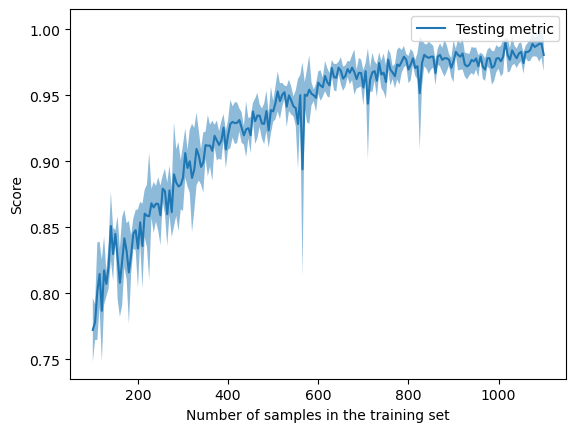

In [138]:
LearningCurveDisplay.from_estimator(
   GradientBoostingClassifier(max_depth=5,
                                     learning_rate=1.0,
                                     n_estimators=300,
                                     subsample=0.86,
                                     random_state=_random_state), X_train, y_train, train_sizes=np.arange(100, 1105, 5), cv=5, scoring='f1')

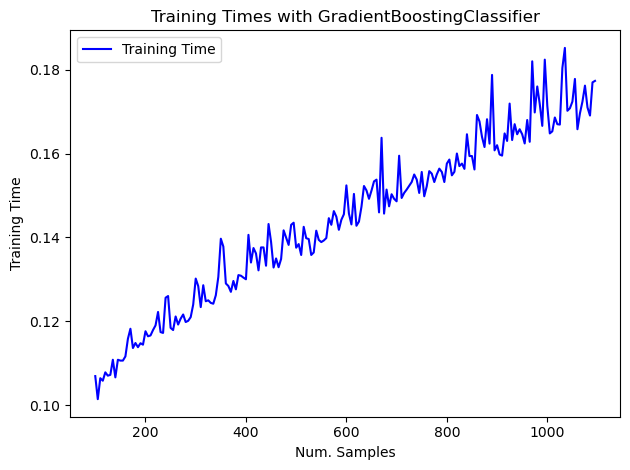

In [139]:
get_training_time(GradientBoostingClassifier(max_depth=5,
                                     learning_rate=1.0,
                                     n_estimators=300,
                                     subsample=0.86,
                                     random_state=_random_state), X_train, y_train)

In [140]:
gb = GradientBoostingClassifier(max_depth=5,
                                     learning_rate=1.0,
                                     n_estimators=300,
                                     subsample=0.86,
                                     random_state=_random_state)

gb = gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

accuracy, f1 = model_evaluation(y_test, y_pred)
print('Accuracy: ', accuracy)
print('F1: ', f1)

Accuracy:  1.0
F1:  1.0


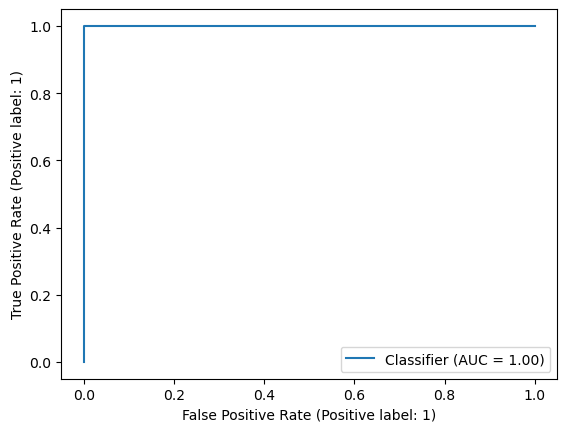

In [141]:
metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

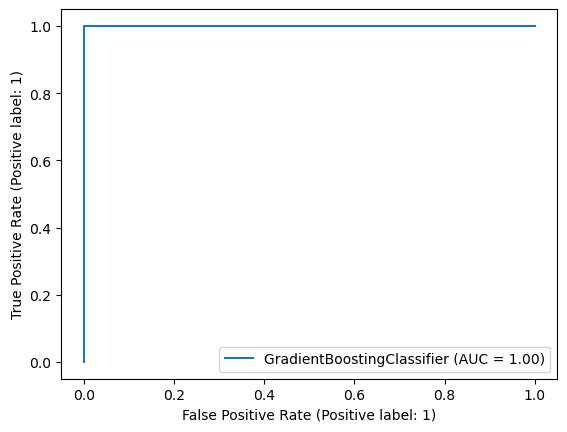

In [142]:
metrics.RocCurveDisplay.from_estimator(gb, X_train, y_train)
plt.show()

## Neural Networks

In [51]:
one_layer_sizes = [(10,), (20,), (30,), (40,), (50,), (60,), (70,), (80,), (90,), (100,), (110,), (120,), (130,), (140,), (150,), (160,), (170,), (180,), (190,), (200,), (250,), (300,)]
two_layer_sizes = [(10,10), (10,20), (20,20), (20,10), (20,30), (30,30), (10,30), (30,10), (30,20), (40,40), (50,50), (60,60), (100,100), (200,200)]
three_layer_sizes = [(10,10,10), (10,20,10), (20,20,20), (20,20,10), (20,30,20), (30,30,30), (20,50,20), (20,100,20), (50,30,10), (50,40,30), (100,50,20), (100,100,20)]

In [54]:
X_train.shape

(1382, 15)

In [40]:
one_layer_train_results = []
one_layer_val_results = []
for i in one_layer_sizes:
    mlp = MLPClassifier(random_state=_random_state, max_iter=400, hidden_layer_sizes=i)
    mlp_result = cross_validation(mlp, X_train, y_train, 5)
    one_layer_train_results.append(mlp_result["Training F1 scores"].mean())
    one_layer_val_results.append(mlp_result["Validation F1 scores"].mean())

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

0.9951661190215407


<Figure size 640x480 with 0 Axes>

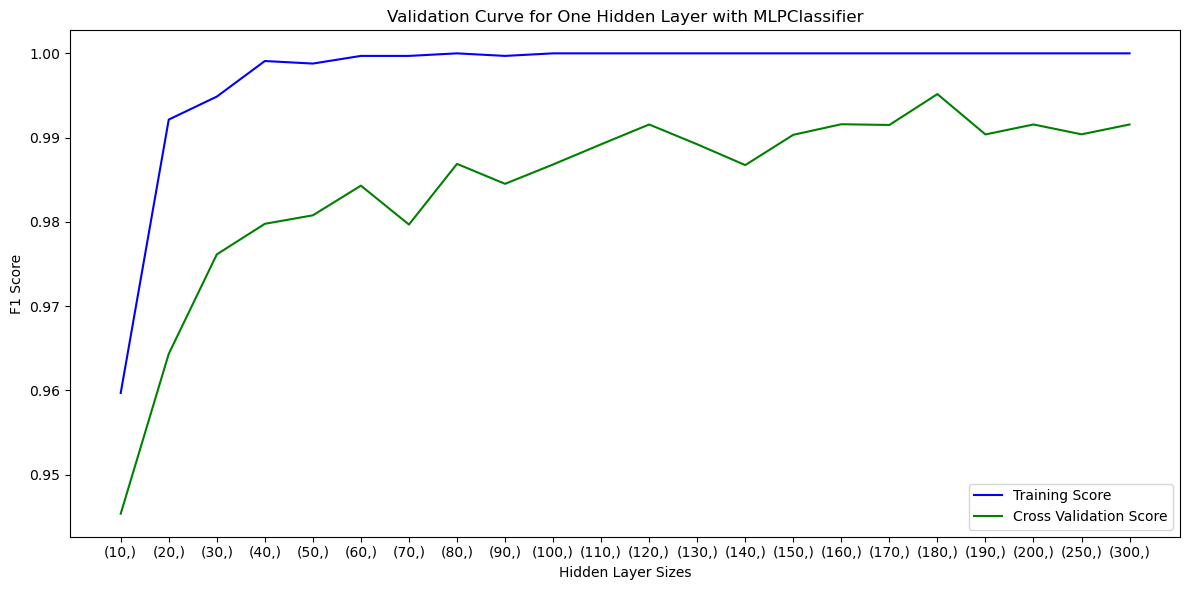

In [41]:
labels = ['(10,)', '(20,)', '(30,)', '(40,)', '(50,)', '(60,)', '(70,)', '(80,)', '(90,)', '(100,)', '(110,)', '(120,)', '(130,)', '(140,)', '(150,)', '(160,)', '(170,)', '(180,)', '(190,)', '(200,)', '(250,)', '(300,)']

fig = plt.figure()
plt.figure(figsize=(12,6))
plt.plot(labels, one_layer_train_results,
    label = "Training Score", color = 'b')
plt.plot(labels, one_layer_val_results,
    label = "Cross Validation Score", color = 'g')

# Creating the plot
plt.title(f"Validation Curve for One Hidden Layer with {mlp.__class__.__name__}")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc = 'best')


print(max(one_layer_val_results))

In [35]:
two_layer_train_results = []
two_layer_val_results = []
for i in two_layer_sizes:
    mlp = MLPClassifier(random_state=_random_state, max_iter=400, hidden_layer_sizes=i)
    mlp_result = cross_validation(mlp, X_train, y_train, 5)
    two_layer_train_results.append(mlp_result["Training F1 scores"].mean())
    two_layer_val_results.append(mlp_result["Validation F1 scores"].mean())

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

0.9939680705515906


<Figure size 640x480 with 0 Axes>

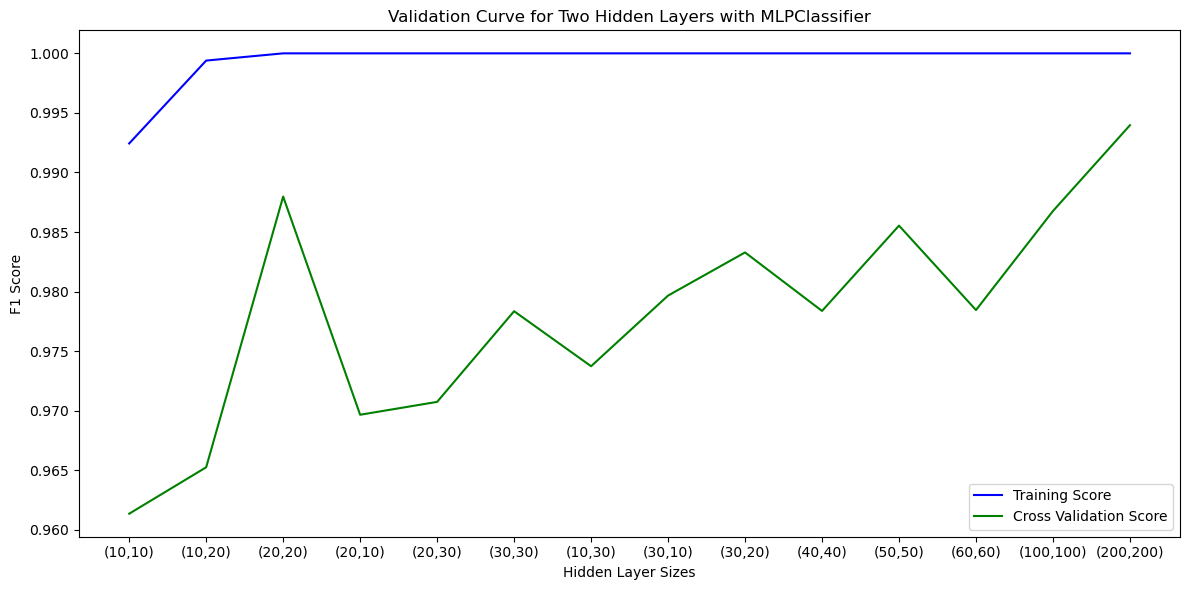

In [36]:
labels = ['(10,10)', '(10,20)', '(20,20)', '(20,10)', '(20,30)', '(30,30)', '(10,30)', '(30,10)', '(30,20)', '(40,40)', '(50,50)', '(60,60)', '(100,100)', '(200,200)']

fig = plt.figure()
plt.figure(figsize=(12,6))
plt.plot(labels, two_layer_train_results,
    label = "Training Score", color = 'b')
plt.plot(labels, two_layer_val_results,
    label = "Cross Validation Score", color = 'g')

# Creating the plot
plt.title(f"Validation Curve for Two Hidden Layers with {mlp.__class__.__name__}")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc = 'best')


print(max(two_layer_val_results))

In [52]:
three_layer_train_results = []
three_layer_val_results = []
for i in three_layer_sizes:
    mlp = MLPClassifier(random_state=_random_state, max_iter=400, hidden_layer_sizes=i)
    mlp_result = cross_validation(mlp, X_train, y_train, 5)
    three_layer_train_results.append(mlp_result["Training F1 scores"].mean())
    three_layer_val_results.append(mlp_result["Validation F1 scores"].mean())

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9879222432576572


<Figure size 640x480 with 0 Axes>

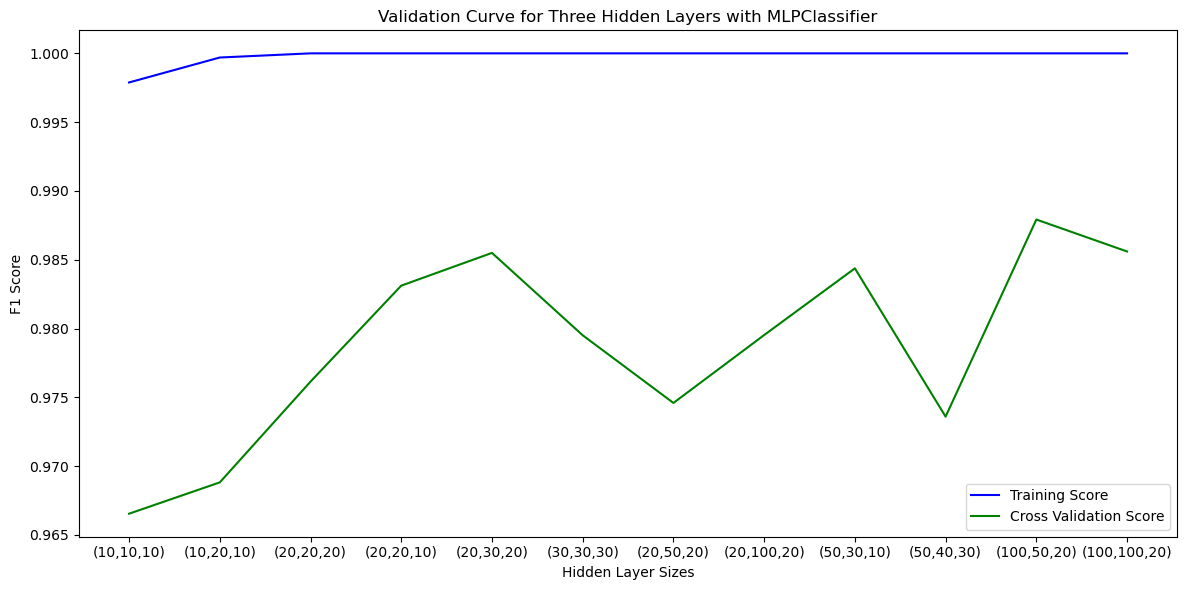

In [53]:
labels = ['(10,10,10)', '(10,20,10)', '(20,20,20)', '(20,20,10)', '(20,30,20)', '(30,30,30)', '(20,50,20)', '(20,100,20)', '(50,30,10)', '(50,40,30)', '(100,50,20)', '(100,100,20)']

fig = plt.figure()
plt.figure(figsize=(12,6))
plt.plot(labels, three_layer_train_results,
    label = "Training Score", color = 'b')
plt.plot(labels, three_layer_val_results,
    label = "Cross Validation Score", color = 'g')

# Creating the plot
plt.title(f"Validation Curve for Three Hidden Layers with {mlp.__class__.__name__}")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc = 'best')


print(max(three_layer_val_results))

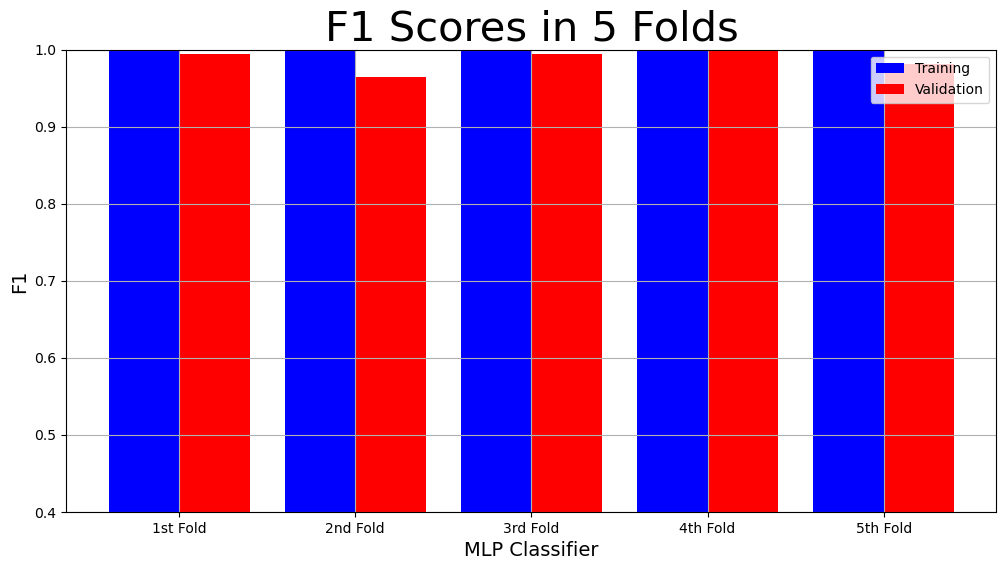

Training:  [1. 1. 1. 1. 1.]
Validation:  [0.99401198 0.96428571 0.99393939 1.         0.98181818]
Train F1 mean:  1.0
Validation F1 mean:  0.9868110532182388


In [54]:
mlp = MLPClassifier(random_state=_random_state, max_iter=400, hidden_layer_sizes=(100,))
mlp_result = cross_validation(mlp, X_train, y_train, 5)

# Plot F1 Result
model_name = "MLP Classifier"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            mlp_result["Training F1 scores"],
            mlp_result["Validation F1 scores"])

print("Training: ", mlp_result["Training F1 scores"])
print("Validation: ", mlp_result["Validation F1 scores"])
print("Train F1 mean: ", mlp_result["Training F1 scores"].mean())
print("Validation F1 mean: ", mlp_result["Validation F1 scores"].mean())

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

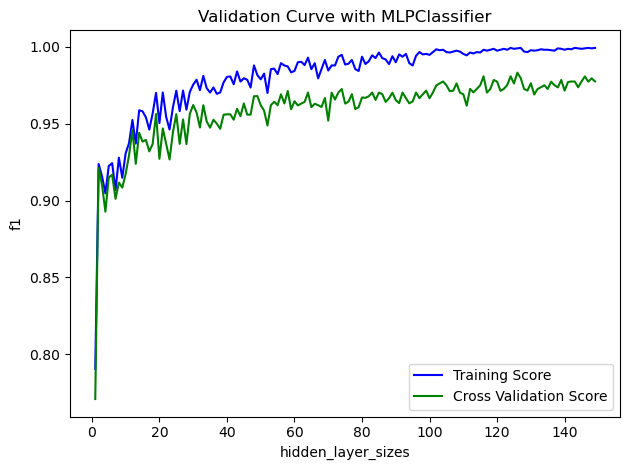

Indices: [125 123 115]
Values: [0.98327258 0.98092068 0.98086453]


In [19]:
## TODO: Run again with 400 max iter

f, train_scores, valid_scores = get_validation_curve(MLPClassifier(random_state=_random_state, max_iter=400), X_train, y_train, "hidden_layer_sizes", 1, 200, 10, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

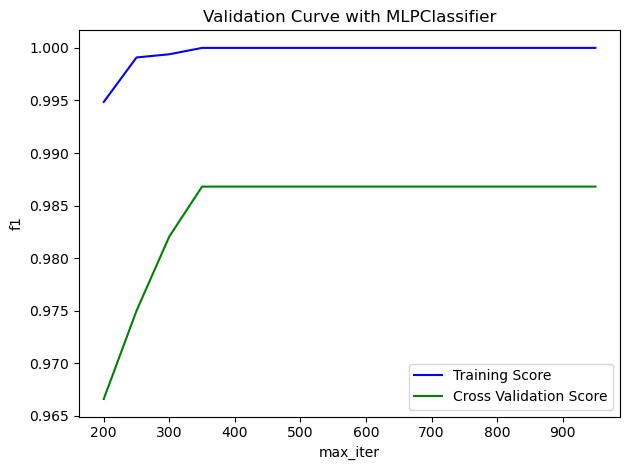

Indices: [15 14 13]
Values: [0.98681105 0.98681105 0.98681105]


In [22]:
f, train_scores, valid_scores = get_validation_curve(MLPClassifier(random_state=_random_state), X_train, y_train, "max_iter", 200, 1000, 50, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

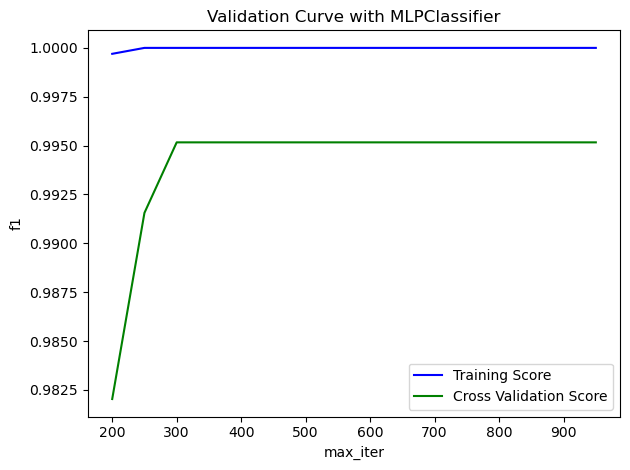

Indices: [15 14 13]
Values: [0.99516612 0.99516612 0.99516612]


In [56]:
f, train_scores, valid_scores = get_validation_curve(MLPClassifier(random_state=_random_state,hidden_layer_sizes=(180,)), X_train, y_train, "max_iter", 200, 1000, 50, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

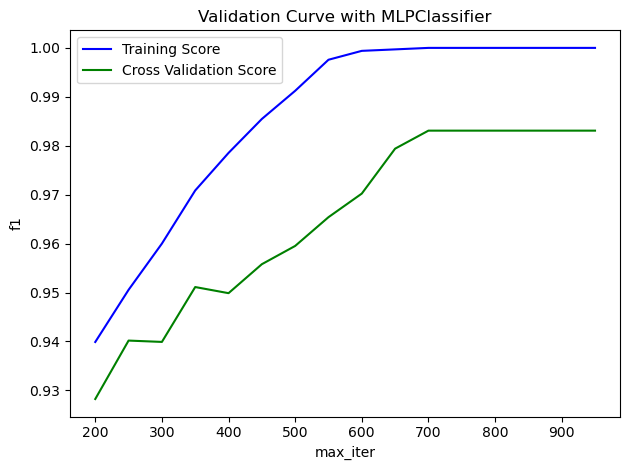

Indices: [15 14 13]
Values: [0.98308845 0.98308845 0.98308845]


In [35]:
f, train_scores, valid_scores = get_validation_curve(MLPClassifier(random_state=_random_state,activation='tanh'), X_train, y_train, "max_iter", 200, 1000, 50, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

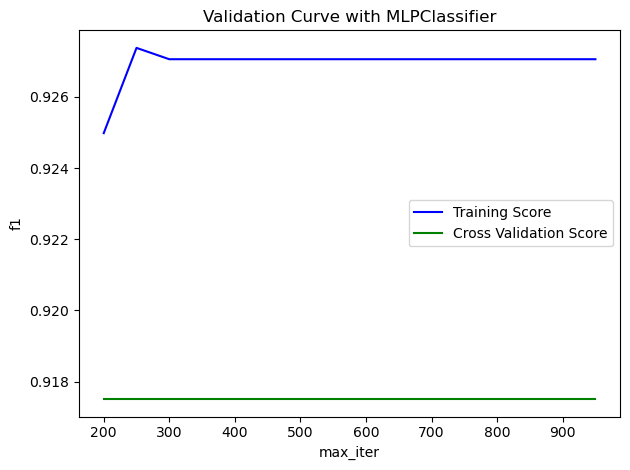

Indices: [15 14 13]
Values: [0.91751162 0.91751162 0.91751162]


In [36]:
f, train_scores, valid_scores = get_validation_curve(MLPClassifier(random_state=_random_state,activation='identity'), X_train, y_train, "max_iter", 200, 1000, 50, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

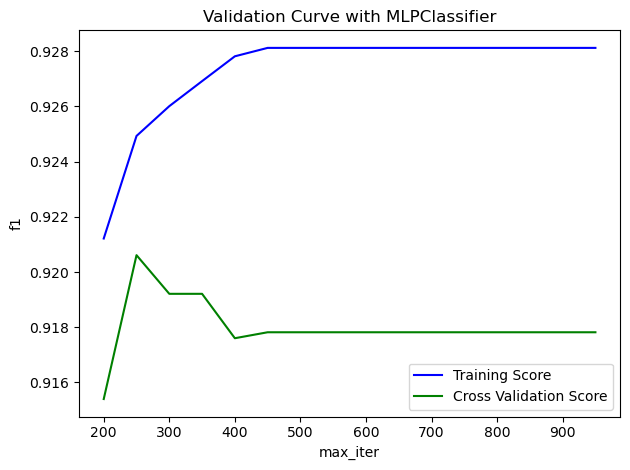

Indices: [1 3 2]
Values: [0.9206117  0.91921096 0.91921096]


In [37]:
f, train_scores, valid_scores = get_validation_curve(MLPClassifier(random_state=_random_state,activation='logistic'), X_train, y_train, "max_iter", 200, 1000, 50, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

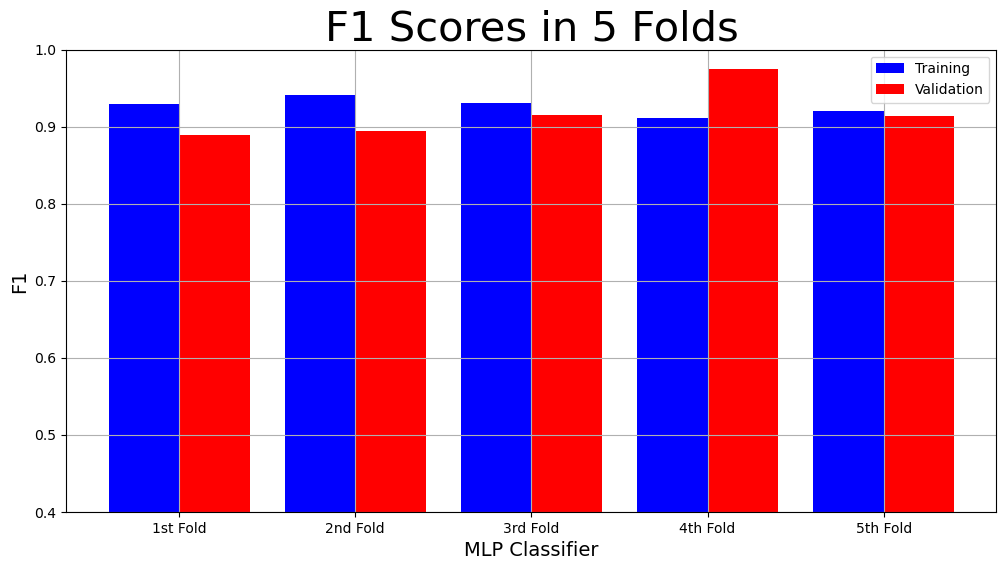

Training:  [0.92995529 0.94117647 0.93134328 0.91180867 0.92101341]
Validation:  [0.88888889 0.89411765 0.91566265 0.97530864 0.91358025]
Train F1 mean:  0.9270594254508495
Validation F1 mean:  0.917511615087802


In [31]:
mlp = MLPClassifier(activation='identity', random_state=_random_state, max_iter=400)
mlp_result = cross_validation(mlp, X_train, y_train, 5)

# Plot F1 Result
model_name = "MLP Classifier"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            mlp_result["Training F1 scores"],
            mlp_result["Validation F1 scores"])

print("Training: ", mlp_result["Training F1 scores"])
print("Validation: ", mlp_result["Validation F1 scores"])
print("Train F1 mean: ", mlp_result["Training F1 scores"].mean())
print("Validation F1 mean: ", mlp_result["Validation F1 scores"].mean())

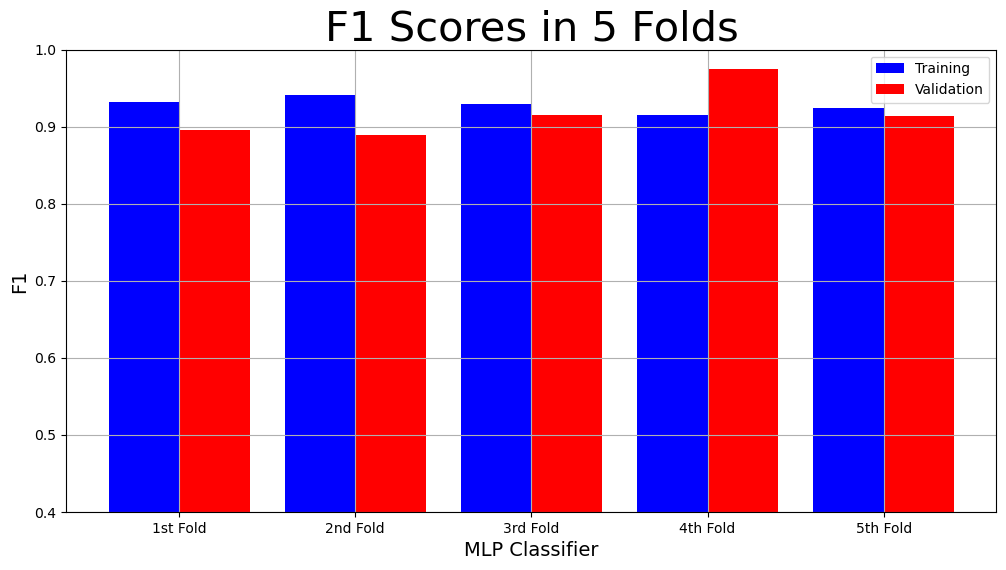

Training:  [0.93154762 0.94099849 0.92899408 0.91530461 0.92376682]
Validation:  [0.89534884 0.88888889 0.91566265 0.97560976 0.91358025]
Train F1 mean:  0.9281223222825524
Validation F1 mean:  0.9178180759423483


In [32]:
mlp = MLPClassifier(activation='logistic', random_state=_random_state, max_iter=500) ## did not converge at 400 max iter, had to increase
mlp_result = cross_validation(mlp, X_train, y_train, 5)

# Plot F1 Result
model_name = "MLP Classifier"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            mlp_result["Training F1 scores"],
            mlp_result["Validation F1 scores"])

print("Training: ", mlp_result["Training F1 scores"])
print("Validation: ", mlp_result["Validation F1 scores"])
print("Train F1 mean: ", mlp_result["Training F1 scores"].mean())
print("Validation F1 mean: ", mlp_result["Validation F1 scores"].mean())

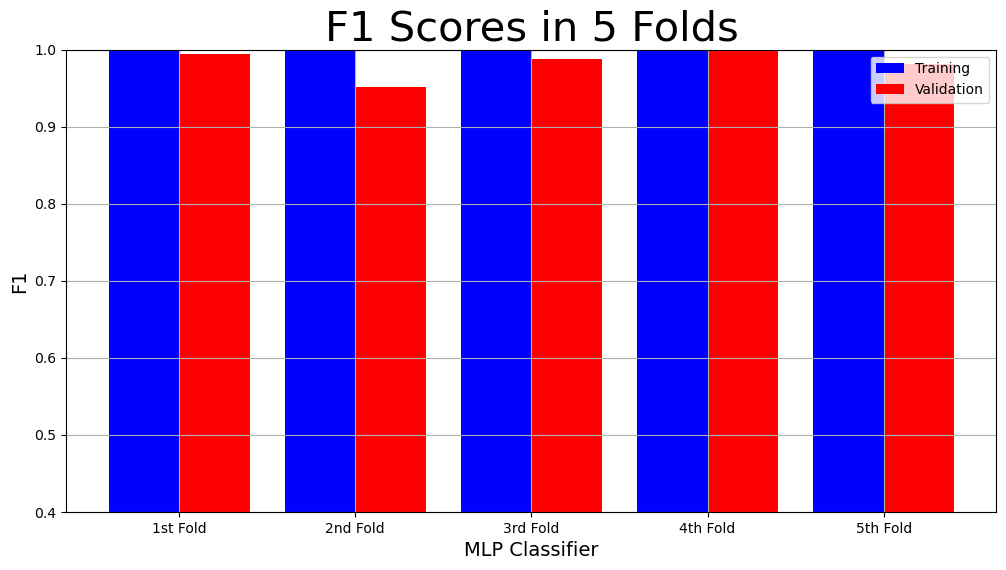

Training:  [1. 1. 1. 1. 1.]
Validation:  [0.99401198 0.95180723 0.98780488 1.         0.98181818]
Train F1 mean:  1.0
Validation F1 mean:  0.9830884529661057


In [33]:
mlp = MLPClassifier(activation='tanh', random_state=_random_state, max_iter=800) ## did not converge at 500, had to increase max iter
mlp_result = cross_validation(mlp, X_train, y_train, 5)

# Plot F1 Result
model_name = "MLP Classifier"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            mlp_result["Training F1 scores"],
            mlp_result["Validation F1 scores"])

print("Training: ", mlp_result["Training F1 scores"])
print("Validation: ", mlp_result["Validation F1 scores"])
print("Train F1 mean: ", mlp_result["Training F1 scores"].mean())
print("Validation F1 mean: ", mlp_result["Validation F1 scores"].mean())

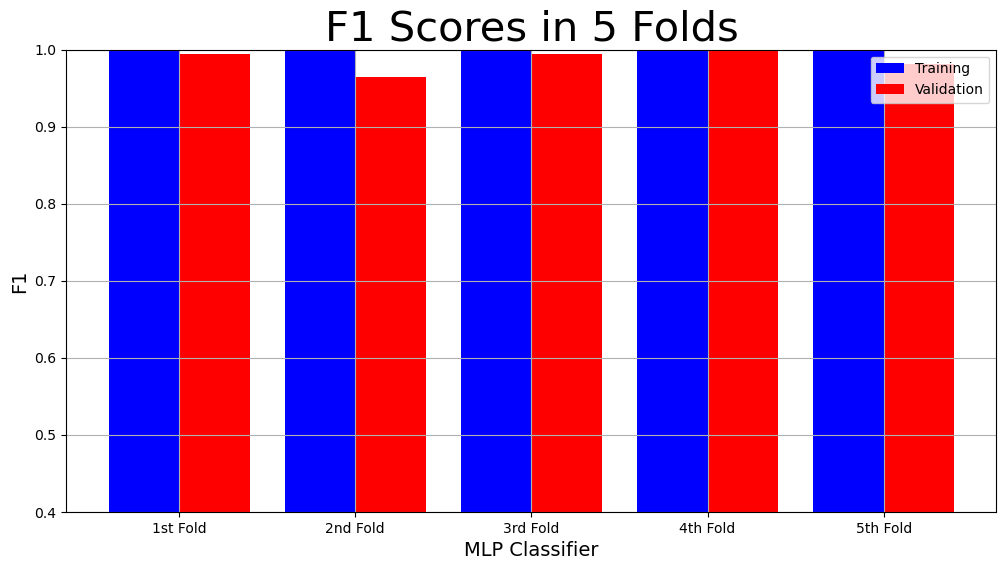

Training:  [1. 1. 1. 1. 1.]
Validation:  [0.99401198 0.96428571 0.99393939 1.         0.98181818]
Train F1 mean:  1.0
Validation F1 mean:  0.9868110532182388


In [34]:
mlp = MLPClassifier(activation='relu', random_state=_random_state, max_iter=400) ## did not converge at 500, had to increase max iter
mlp_result = cross_validation(mlp, X_train, y_train, 5)

# Plot F1 Result
model_name = "MLP Classifier"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            mlp_result["Training F1 scores"],
            mlp_result["Validation F1 scores"])

print("Training: ", mlp_result["Training F1 scores"])
print("Validation: ", mlp_result["Validation F1 scores"])
print("Train F1 mean: ", mlp_result["Training F1 scores"].mean())
print("Validation F1 mean: ", mlp_result["Validation F1 scores"].mean())

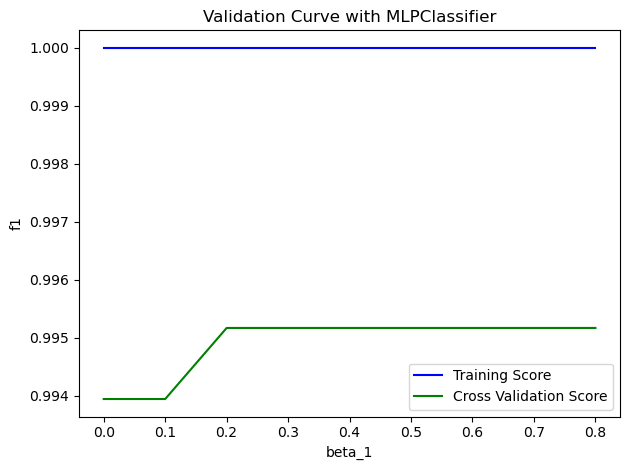

Indices: [8 7 6]
Values: [0.99516612 0.99516612 0.99516612]


In [55]:
f, train_scores, valid_scores = get_validation_curve(MLPClassifier(random_state=_random_state, max_iter=400, hidden_layer_sizes=(180,)), X_train, y_train, "beta_1", 0, 0.9, 0.1, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

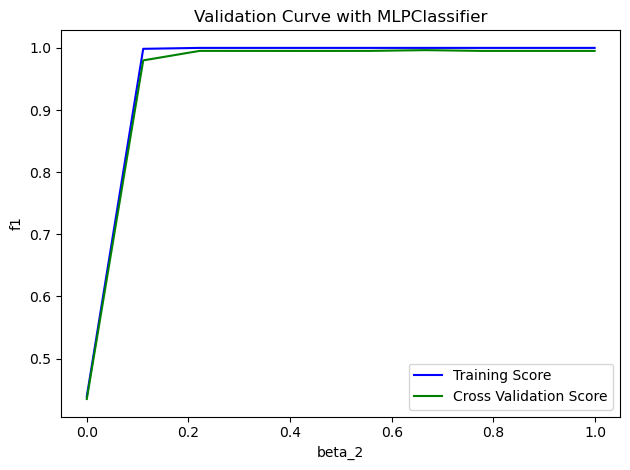

Indices: [6 5 2]
Values: [0.99637815 0.99518055 0.99517993]


In [60]:
f, train_scores, valid_scores = get_validation_curve(MLPClassifier(random_state=_random_state, max_iter=400, hidden_layer_sizes=(180,)), X_train, y_train, "beta_2", 0, 1.0, 0.111, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

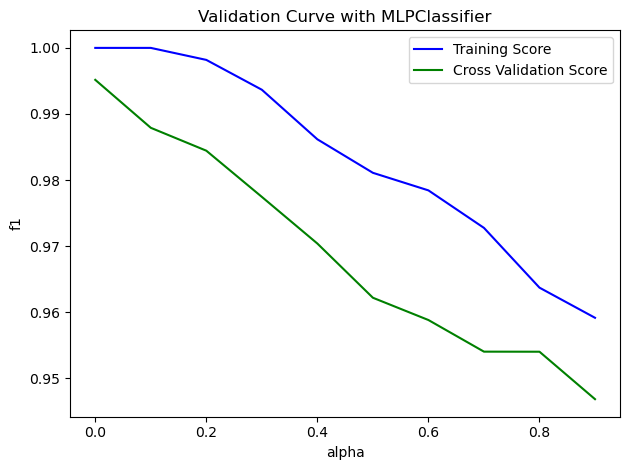

Indices: [0 1 2]
Values: [0.99516612 0.9879073  0.98444409]


In [57]:
f, train_scores, valid_scores = get_validation_curve(MLPClassifier(random_state=_random_state, max_iter=400, hidden_layer_sizes=(180,)), X_train, y_train, "alpha", 0.0001, 1.0, 0.1, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

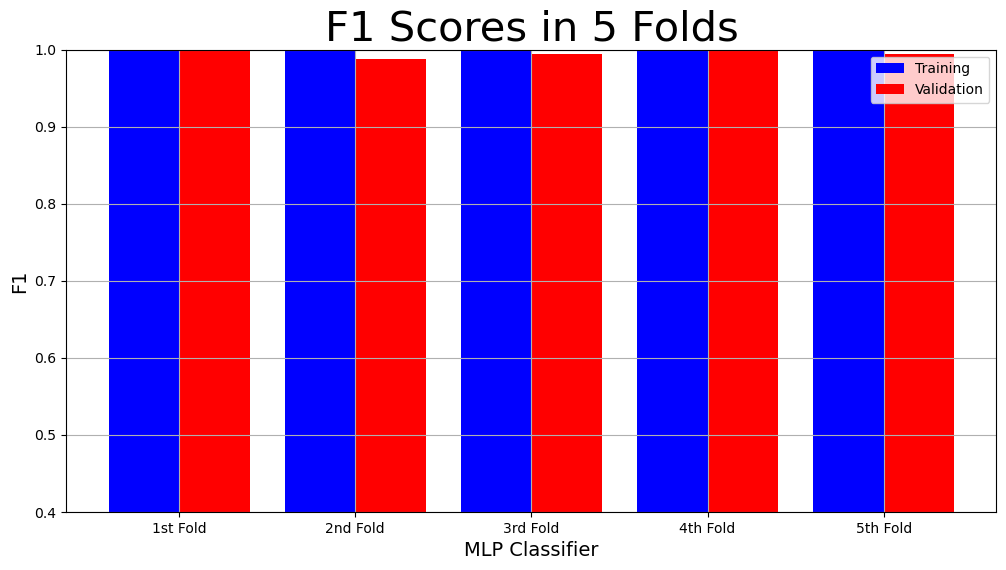

Training:  [1. 1. 1. 1. 1.]
Validation:  [1.         0.98795181 0.99393939 1.         0.99393939]
Train F1 mean:  1.0
Validation F1 mean:  0.9951661190215407


In [65]:
mlp = MLPClassifier(random_state=_random_state, max_iter=400, hidden_layer_sizes=(180,)) ## did not converge at 500, had to increase max iter
mlp_result = cross_validation(mlp, X_train, y_train, 5)

# Plot F1 Result
model_name = "MLP Classifier"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            mlp_result["Training F1 scores"],
            mlp_result["Validation F1 scores"])

print("Training: ", mlp_result["Training F1 scores"])
print("Validation: ", mlp_result["Validation F1 scores"])
print("Train F1 mean: ", mlp_result["Training F1 scores"].mean())
print("Validation F1 mean: ", mlp_result["Validation F1 scores"].mean())

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

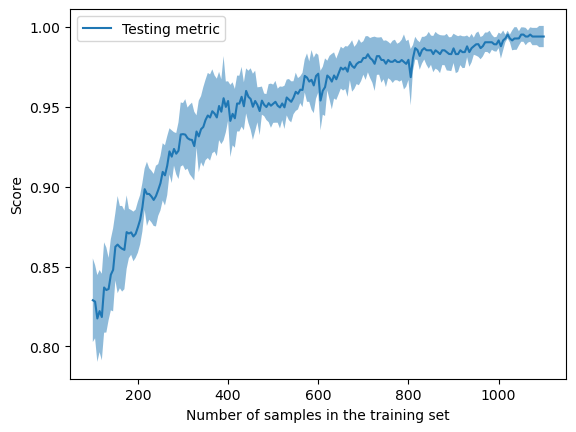

In [67]:
LearningCurveDisplay.from_estimator(
   MLPClassifier(random_state=_random_state, max_iter=400, hidden_layer_sizes=(180,)), X_train, y_train, train_sizes=np.arange(100, 1105, 5), cv=5, scoring='f1')

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

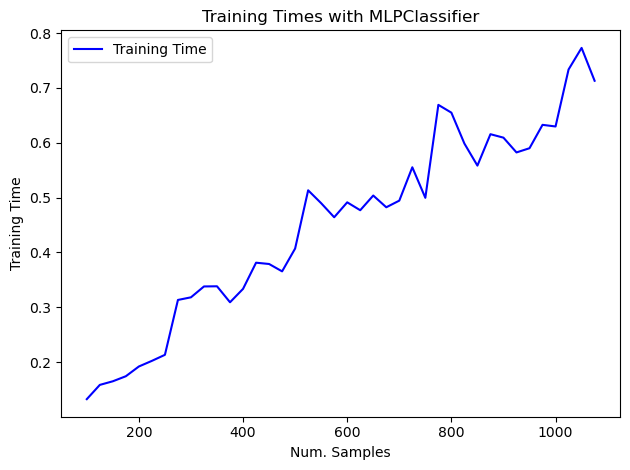

In [71]:
get_training_time(MLPClassifier(random_state=_random_state, max_iter=400, hidden_layer_sizes=(180,)), X_train, y_train)

In [75]:
mlp = MLPClassifier(random_state=_random_state, max_iter=400, hidden_layer_sizes=(180,))

mlp = mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

accuracy, f1 = model_evaluation(y_test, y_pred)
print('Accuracy: ', accuracy)
print('F1: ', f1)

Accuracy:  0.9971098265895953
F1:  0.9953051643192489


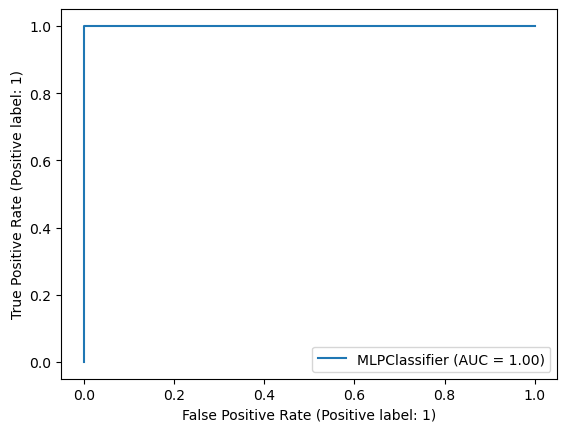

In [76]:
metrics.RocCurveDisplay.from_estimator(mlp, X_train, y_train)
plt.show()

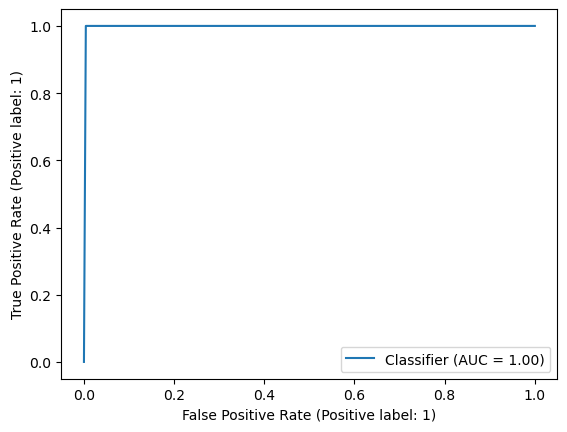

In [77]:
metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

## Support Vector Machines

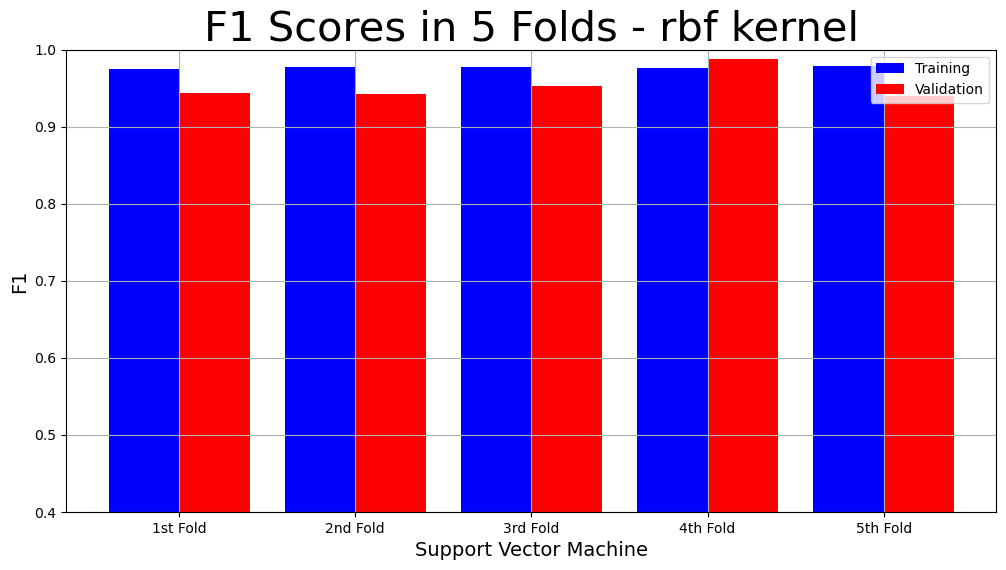

Train F1:  [0.97473997 0.97771174 0.97777778 0.97626113 0.97922849]
Validation F1:  [0.94318182 0.94252874 0.95294118 0.98795181 0.94047619]
Average Validation F1:  0.9534159455979392


In [79]:
svc = SVC(random_state=_random_state)
svc_result = cross_validation(svc, X_train, y_train, 5)

# Plot F1 Result
model_name = "Support Vector Machine"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds - rbf kernel",
            svc_result["Training F1 scores"],
            svc_result["Validation F1 scores"])

print("Train F1: ", svc_result["Training F1 scores"])
print("Validation F1: ", svc_result["Validation F1 scores"])
print("Average Validation F1: ", np.mean(svc_result["Validation F1 scores"]))

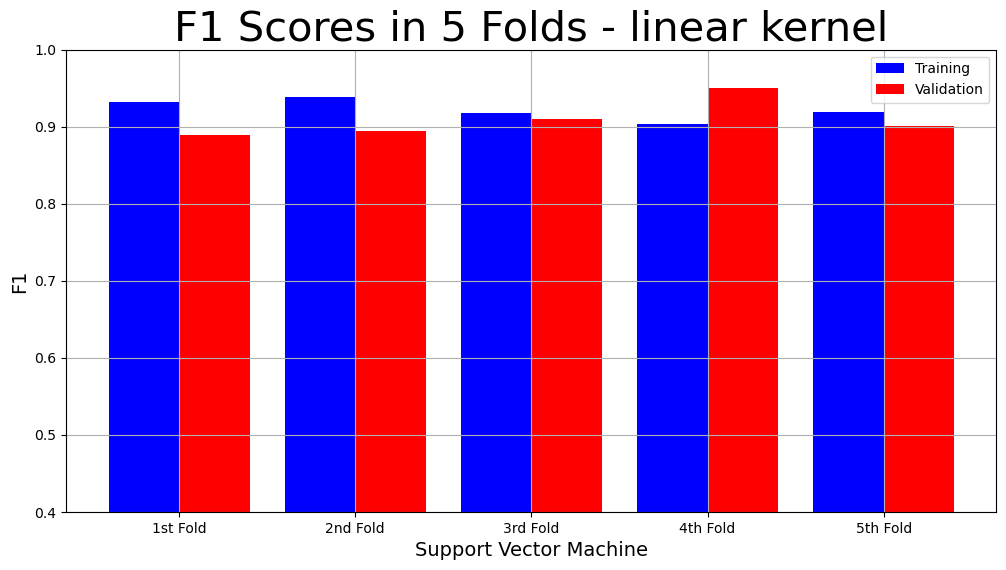

Train F1:  [0.93253373 0.93834586 0.91778774 0.90341753 0.91940299]
Validation F1:  [0.88888889 0.89411765 0.91017964 0.95061728 0.90123457]
Average Validation F1:  0.9090076057036255


In [80]:
svc = SVC(random_state=_random_state, kernel='linear')
svc_result = cross_validation(svc, X_train, y_train, 5)

# Plot F1 Result
model_name = "Support Vector Machine"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds - linear kernel",
            svc_result["Training F1 scores"],
            svc_result["Validation F1 scores"])

print("Train F1: ", svc_result["Training F1 scores"])
print("Validation F1: ", svc_result["Validation F1 scores"])
print("Average Validation F1: ", np.mean(svc_result["Validation F1 scores"]))

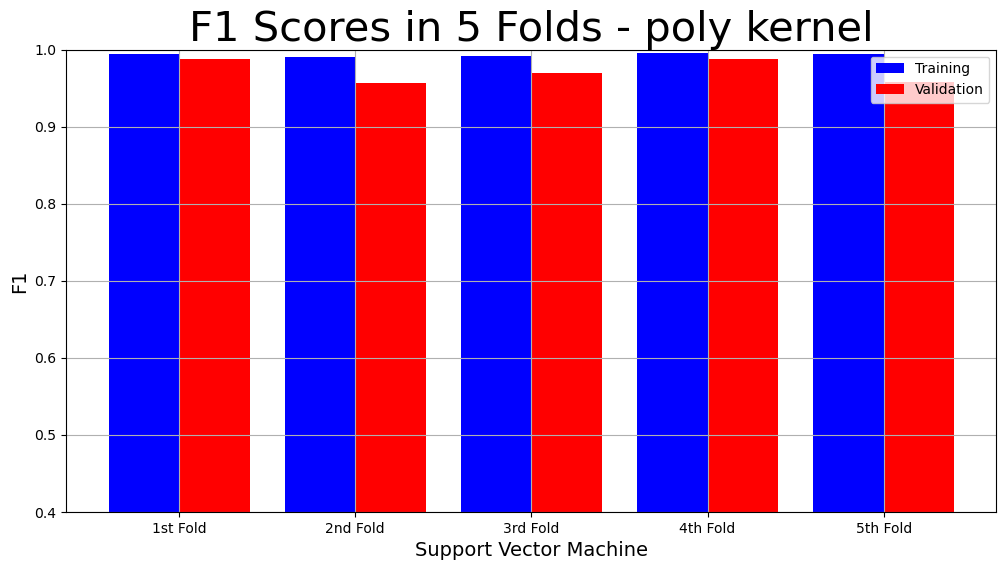

Train F1:  [0.99392097 0.99082569 0.9924357  0.99543379 0.99392097]
Validation F1:  [0.98795181 0.95705521 0.97005988 0.98765432 0.95757576]
Average Validation F1:  0.972059396151155


In [81]:
svc = SVC(random_state=_random_state, kernel='poly')
svc_result = cross_validation(svc, X_train, y_train, 5)

# Plot F1 Result
model_name = "Support Vector Machine"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds - poly kernel",
            svc_result["Training F1 scores"],
            svc_result["Validation F1 scores"])

print("Train F1: ", svc_result["Training F1 scores"])
print("Validation F1: ", svc_result["Validation F1 scores"])
print("Average Validation F1: ", np.mean(svc_result["Validation F1 scores"]))

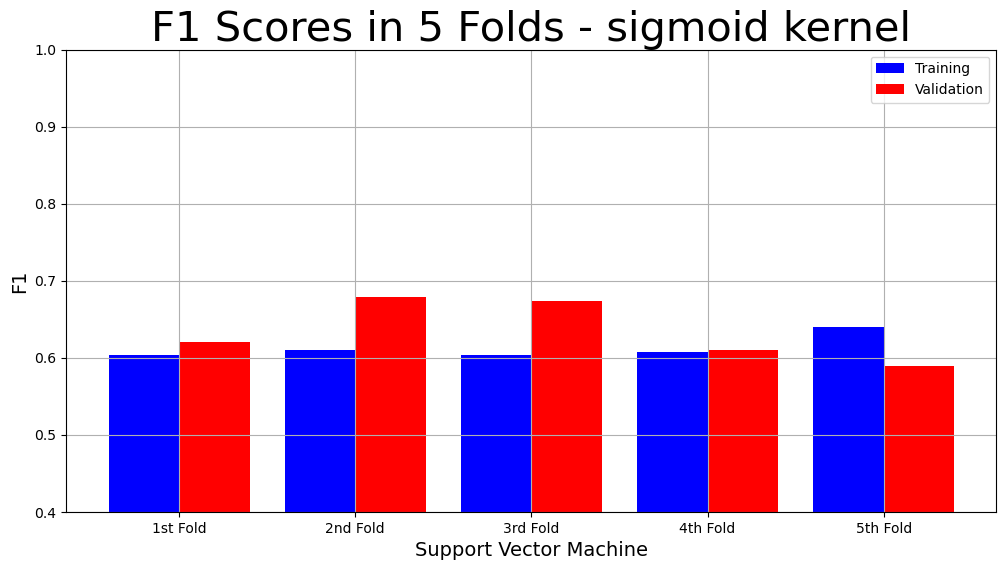

Train F1:  [0.60342146 0.61016949 0.60400616 0.60736196 0.64012251]
Validation F1:  [0.62025316 0.67857143 0.6741573  0.60992908 0.58974359]
Average Validation F1:  0.6345309128513903


In [82]:
svc = SVC(random_state=_random_state, kernel='sigmoid')
svc_result = cross_validation(svc, X_train, y_train, 5)

# Plot F1 Result
model_name = "Support Vector Machine"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds - sigmoid kernel",
            svc_result["Training F1 scores"],
            svc_result["Validation F1 scores"])

print("Train F1: ", svc_result["Training F1 scores"])
print("Validation F1: ", svc_result["Validation F1 scores"])
print("Average Validation F1: ", np.mean(svc_result["Validation F1 scores"]))

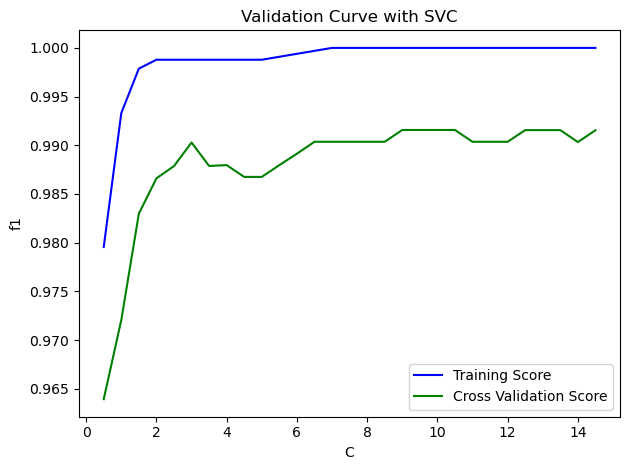

Indices: [ 0 21 18]
Values: [       nan 0.99157296 0.99157296]


In [90]:
f, train_scores, valid_scores = get_validation_curve(SVC(random_state=_random_state, kernel='poly'), X_train, y_train, "C", 0, 15, 0.5, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

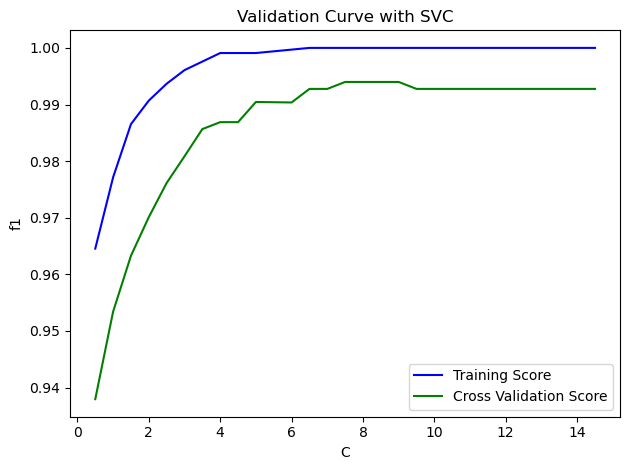

Indices: [ 0 15 16]
Values: [       nan 0.99398303 0.99398303]


In [91]:
# 7.5, default kernel performs better

f, train_scores, valid_scores = get_validation_curve(SVC(random_state=_random_state), X_train, y_train, "C", 0, 15, 0.5, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

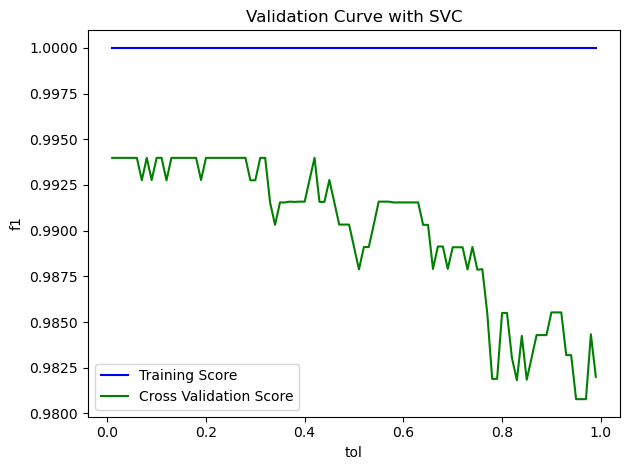

Indices: [ 0 15 42]
Values: [       nan 0.99398303 0.99398303]


In [110]:
f, train_scores, valid_scores = get_validation_curve(SVC(random_state=_random_state, C=7.5), X_train, y_train, "tol", 0, 1, 0.01, 'f1')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

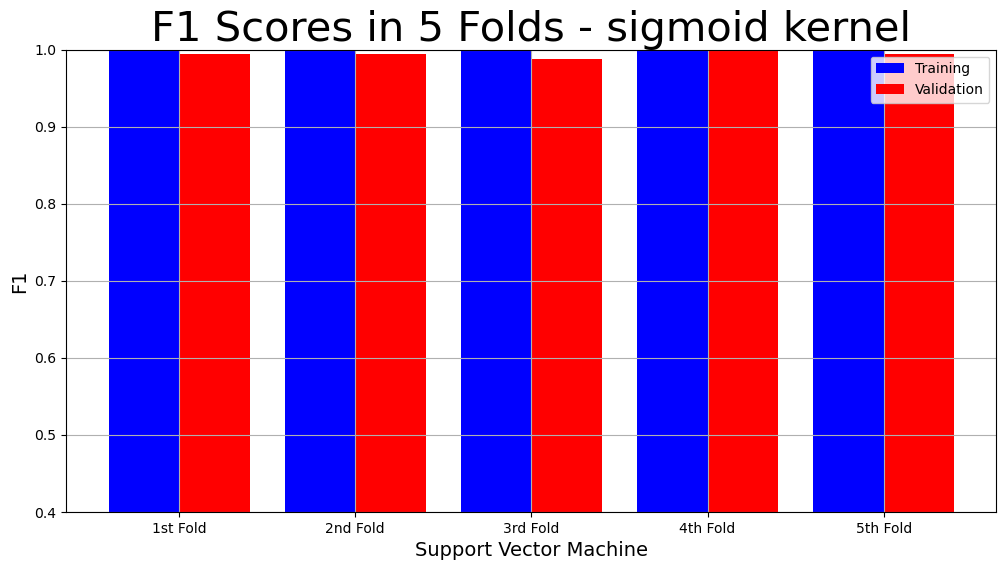

Train F1:  [1. 1. 1. 1. 1.]
Validation F1:  [0.99401198 0.99401198 0.98795181 1.         0.99393939]
Average Validation F1:  0.9939830306528237


In [98]:
# shrinking = True has no effect

svc = SVC(random_state=_random_state, shrinking=True, C=7.5)
svc_result = cross_validation(svc, X_train, y_train, 5)

# Plot F1 Result
model_name = "Support Vector Machine"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds - sigmoid kernel",
            svc_result["Training F1 scores"],
            svc_result["Validation F1 scores"])

print("Train F1: ", svc_result["Training F1 scores"])
print("Validation F1: ", svc_result["Validation F1 scores"])
print("Average Validation F1: ", np.mean(svc_result["Validation F1 scores"]))

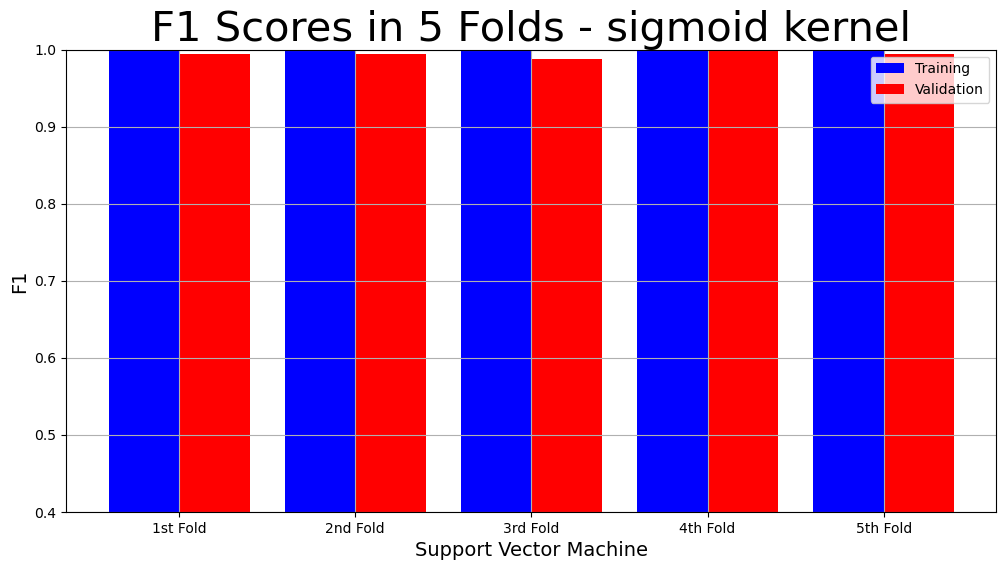

Train F1:  [1. 1. 1. 1. 1.]
Validation F1:  [0.99401198 0.99401198 0.98795181 1.         0.99393939]
Average Validation F1:  0.9939830306528237


In [107]:
# poly kernel is better with default for all other hyperparameters
# default kernel is better once we introduce C=7.5

svc = SVC(random_state=_random_state, C=7.5, decision_function_shape='ovo')
svc_result = cross_validation(svc, X_train, y_train, 5)

# Plot F1 Result
model_name = "Support Vector Machine"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds - sigmoid kernel",
            svc_result["Training F1 scores"],
            svc_result["Validation F1 scores"])

print("Train F1: ", svc_result["Training F1 scores"])
print("Validation F1: ", svc_result["Validation F1 scores"])
print("Average Validation F1: ", np.mean(svc_result["Validation F1 scores"]))

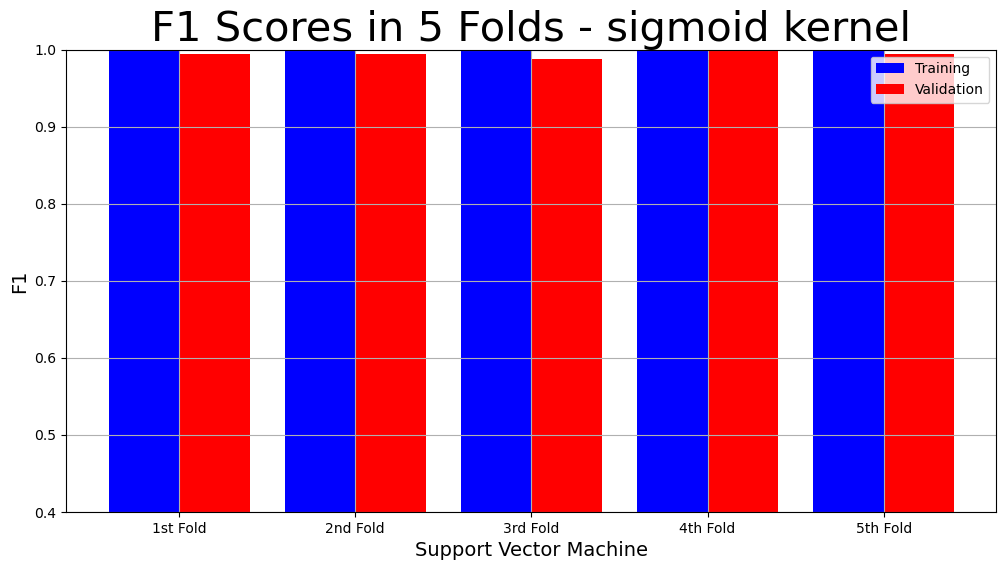

Train F1:  [1. 1. 1. 1. 1.]
Validation F1:  [0.99401198 0.99401198 0.98795181 1.         0.99393939]
Average Validation F1:  0.9939830306528237


In [108]:
# probability = True has no effect

svc = SVC(random_state=_random_state, C=7.5, probability=True)
svc_result = cross_validation(svc, X_train, y_train, 5)

# Plot F1 Result
model_name = "Support Vector Machine"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds - sigmoid kernel",
            svc_result["Training F1 scores"],
            svc_result["Validation F1 scores"])

print("Train F1: ", svc_result["Training F1 scores"])
print("Validation F1: ", svc_result["Validation F1 scores"])
print("Average Validation F1: ", np.mean(svc_result["Validation F1 scores"]))

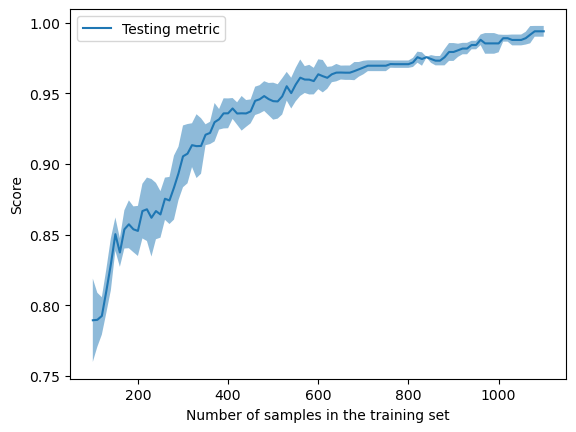

In [111]:
LearningCurveDisplay.from_estimator(SVC(random_state=_random_state, C=7.5), X_train, y_train, train_sizes=np.arange(100, 1105, 10), cv=5, scoring='f1')

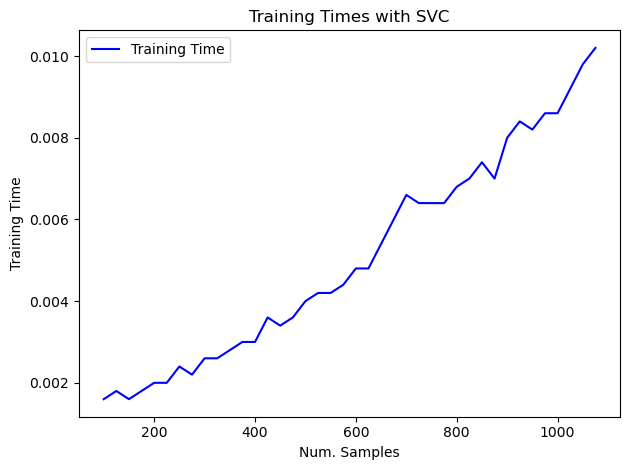

In [112]:
get_training_time(SVC(random_state=_random_state, C=7.5), X_train, y_train)

In [113]:
svc = SVC(random_state=_random_state, C=7.5)

svc = svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy, f1 = model_evaluation(y_test, y_pred)
print('Accuracy: ', accuracy)
print('F1: ', f1)

Accuracy:  0.9971098265895953
F1:  0.9953051643192489


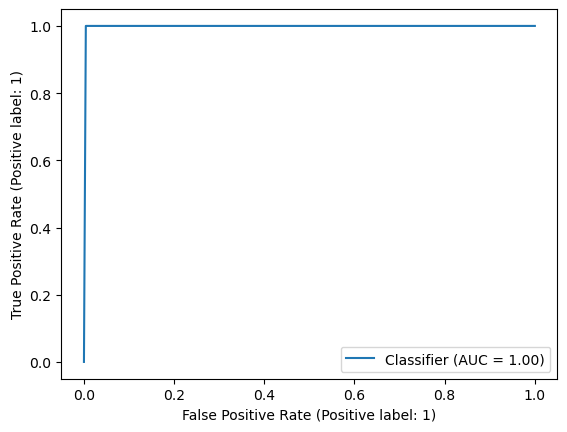

In [114]:
metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

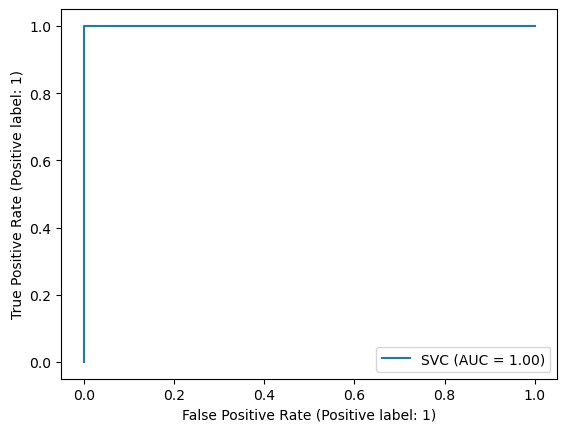

In [115]:
metrics.RocCurveDisplay.from_estimator(svc, X_train, y_train)
plt.show()